In [1]:
import random
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import learn2learn as l2l
from torch import nn, optim
start = time.time()

In [2]:
from learn2learn.data.transforms import (NWays, KShots, LoadData, RemapLabels, ConsecutiveLabels)

In [3]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

In [4]:
def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

In [5]:
ways=5
shots=5
meta_lr=0.003
fast_lr=0.5
meta_batch_size=32
adaptation_steps=1
num_iterations= 10000
cuda=True
seed=42

In [6]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda and torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets('omniglot', train_ways=ways, train_samples=2*shots, test_ways=ways, test_samples=2*shots, num_tasks=20000, root='~/data')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
model.to(device)
maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
opt = optim.Adam(maml.parameters(), meta_lr)
loss = nn.CrossEntropyLoss(reduction='mean')

In [8]:
print(maml)

MAML(
  (module): OmniglotFC(
    (features): Sequential(
      (0): Flatten()
      (1): Sequential(
        (0): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(256, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=784, out_features=256, bias=True)
        )
        (1): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(128, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=256, out_features=128, bias=True)
        )
        (2): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(64, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=128, out_features=64, bias=True)
        )
        (3): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(64, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): 

In [9]:
no_of_iternation = []
meta_train_err = []
meta_train_acc = []
meta_val_err = []
meta_val_acc = []

for iteration in range(num_iterations):
    
    opt.zero_grad()
    meta_train_error = 0.0
    meta_train_accuracy = 0.0
    meta_valid_error = 0.0
    meta_valid_accuracy = 0.0
    for task in range(meta_batch_size):
        # Compute meta-training loss
        learner = maml.clone()
        batch = tasksets.train.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        evaluation_error.backward()
        meta_train_error += evaluation_error.item()
        meta_train_accuracy += evaluation_accuracy.item()

        # Compute meta-validation loss
        learner = maml.clone()
        batch = tasksets.validation.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_valid_error += evaluation_error.item()
        meta_valid_accuracy += evaluation_accuracy.item()

    # Print some metrics
    print('\n')
    print('Iteration', iteration)
    no_of_iternation.append(iteration)
    print('Meta Train Error', meta_train_error / meta_batch_size)
    meta_train_err.append(meta_train_error / meta_batch_size)
    print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
    meta_train_acc.append(meta_train_accuracy / meta_batch_size)
    print('Meta Valid Error', meta_valid_error / meta_batch_size)
    meta_val_err.append(meta_valid_error / meta_batch_size)
    print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)
    meta_val_acc.append(meta_valid_accuracy / meta_batch_size)

    # Average the accumulated gradients and optimize
    for p in maml.parameters():
        p.grad.data.mul_(1.0 / meta_batch_size)
    opt.step()

meta_test_error = 0.0
meta_test_accuracy = 0.0



Iteration 0
Meta Train Error 1.517993114888668
Meta Train Accuracy 0.38249998865649104
Meta Valid Error 1.5413377285003662
Meta Valid Accuracy 0.3462499894667417


Iteration 1
Meta Train Error 1.4882976412773132
Meta Train Accuracy 0.35749999224208295
Meta Valid Error 1.447393488138914
Meta Valid Accuracy 0.38374999025836587


Iteration 2
Meta Train Error 1.3109942339360714
Meta Train Accuracy 0.49749998608604074
Meta Valid Error 1.351663000881672
Meta Valid Accuracy 0.43624998768791556


Iteration 3
Meta Train Error 1.188947781920433
Meta Train Accuracy 0.5574999926611781
Meta Valid Error 1.2165516763925552
Meta Valid Accuracy 0.5424999855458736


Iteration 4
Meta Train Error 1.1130631249397993
Meta Train Accuracy 0.5799999823793769
Meta Valid Error 1.1035738363862038
Meta Valid Accuracy 0.5924999825656414


Iteration 5
Meta Train Error 1.0597006529569626
Meta Train Accuracy 0.5937499841675162
Meta Valid Error 1.0468864310532808
Meta Valid Accuracy 0.6049999790266156


Iteration 6
M



Iteration 50
Meta Train Error 0.6098520196974277
Meta Train Accuracy 0.7912499774247408
Meta Valid Error 0.578099187463522
Meta Valid Accuracy 0.7962499745190144


Iteration 51
Meta Train Error 0.5652960841543972
Meta Train Accuracy 0.7849999740719795
Meta Valid Error 0.5430419673211873
Meta Valid Accuracy 0.816249979659915


Iteration 52
Meta Train Error 0.5213040290400386
Meta Train Accuracy 0.8312499802559614
Meta Valid Error 0.5198374385945499
Meta Valid Accuracy 0.8212499767541885


Iteration 53
Meta Train Error 0.580192681401968
Meta Train Accuracy 0.7912499774247408
Meta Valid Error 0.5797701003029943
Meta Valid Accuracy 0.7912499736994505


Iteration 54
Meta Train Error 0.5927643883042037
Meta Train Accuracy 0.7924999762326479
Meta Valid Error 0.5305784214287996
Meta Valid Accuracy 0.811249976977706


Iteration 55
Meta Train Error 0.6151037430390716
Meta Train Accuracy 0.7874999782070518
Meta Valid Error 0.5182049949653447
Meta Valid Accuracy 0.8237499762326479


Iteration 56



Iteration 100
Meta Train Error 0.4481612164527178
Meta Train Accuracy 0.8387499758973718
Meta Valid Error 0.4245422752574086
Meta Valid Accuracy 0.8487499803304672


Iteration 101
Meta Train Error 0.3645769748836756
Meta Train Accuracy 0.8874999787658453
Meta Valid Error 0.41425775829702616
Meta Valid Accuracy 0.8549999790266156


Iteration 102
Meta Train Error 0.4191820800770074
Meta Train Accuracy 0.861249977722764
Meta Valid Error 0.393401195993647
Meta Valid Accuracy 0.8624999802559614


Iteration 103
Meta Train Error 0.39742524246685207
Meta Train Accuracy 0.8549999762326479
Meta Valid Error 0.4017061518970877
Meta Valid Accuracy 0.8662499748170376


Iteration 104
Meta Train Error 0.4436636916361749
Meta Train Accuracy 0.8487499747425318
Meta Valid Error 0.44487945712171495
Meta Valid Accuracy 0.8387499786913395


Iteration 105
Meta Train Error 0.4123189812526107
Meta Train Accuracy 0.8599999789148569
Meta Valid Error 0.48233924014493823
Meta Valid Accuracy 0.8074999824166298






Iteration 150
Meta Train Error 0.3210003214189783
Meta Train Accuracy 0.8899999782443047
Meta Valid Error 0.34090315643697977
Meta Valid Accuracy 0.8874999824911356


Iteration 151
Meta Train Error 0.3773919164086692
Meta Train Accuracy 0.8574999775737524
Meta Valid Error 0.38374731852672994
Meta Valid Accuracy 0.8599999789148569


Iteration 152
Meta Train Error 0.2783372823614627
Meta Train Accuracy 0.9049999825656414
Meta Valid Error 0.35019954084418714
Meta Valid Accuracy 0.8749999739229679


Iteration 153
Meta Train Error 0.3187846833607182
Meta Train Accuracy 0.8887499757111073
Meta Valid Error 0.3365236596437171
Meta Valid Accuracy 0.8674999810755253


Iteration 154
Meta Train Error 0.2970701886806637
Meta Train Accuracy 0.8974999766796827
Meta Valid Error 0.32318129925988615
Meta Valid Accuracy 0.8849999774247408


Iteration 155
Meta Train Error 0.33028763229958713
Meta Train Accuracy 0.8974999729543924
Meta Valid Error 0.3269833386875689
Meta Valid Accuracy 0.881249975413084




Iteration 200
Meta Train Error 0.32342847500694916
Meta Train Accuracy 0.889999981969595
Meta Valid Error 0.29916501918341964
Meta Valid Accuracy 0.904999976977706


Iteration 201
Meta Train Error 0.24759063048986718
Meta Train Accuracy 0.9237499814480543
Meta Valid Error 0.3680189365404658
Meta Valid Accuracy 0.886249978095293


Iteration 202
Meta Train Error 0.2656445326283574
Meta Train Accuracy 0.9162499755620956
Meta Valid Error 0.2758858341840096
Meta Valid Accuracy 0.9099999777972698


Iteration 203
Meta Train Error 0.27479890442918986
Meta Train Accuracy 0.9087499789893627
Meta Valid Error 0.292807562276721
Meta Valid Accuracy 0.9074999801814556


Iteration 204
Meta Train Error 0.21413442539051175
Meta Train Accuracy 0.9249999783933163
Meta Valid Error 0.23608379781944677
Meta Valid Accuracy 0.9074999764561653


Iteration 205
Meta Train Error 0.3415596658596769
Meta Train Accuracy 0.8874999731779099
Meta Valid Error 0.3340614923508838
Meta Valid Accuracy 0.8812499772757292






Iteration 250
Meta Train Error 0.20862431440036744
Meta Train Accuracy 0.9287499822676182
Meta Valid Error 0.3094932562671602
Meta Valid Accuracy 0.8899999763816595


Iteration 251
Meta Train Error 0.25916649770806544
Meta Train Accuracy 0.9137499816715717
Meta Valid Error 0.28114556398941204
Meta Valid Accuracy 0.903749980032444


Iteration 252
Meta Train Error 0.3149049849016592
Meta Train Accuracy 0.8962499760091305
Meta Valid Error 0.2457697848440148
Meta Valid Accuracy 0.9062499776482582


Iteration 253
Meta Train Error 0.18658778560347855
Meta Train Accuracy 0.9349999837577343
Meta Valid Error 0.21845311275683343
Meta Valid Accuracy 0.9312499817460775


Iteration 254
Meta Train Error 0.20393291470827535
Meta Train Accuracy 0.9349999837577343
Meta Valid Error 0.20503838936565444
Meta Valid Accuracy 0.9337499793618917


Iteration 255
Meta Train Error 0.25506358593702316
Meta Train Accuracy 0.9212499782443047
Meta Valid Error 0.26485390786547214
Meta Valid Accuracy 0.9049999788403



Iteration 300
Meta Train Error 0.24529503530357033
Meta Train Accuracy 0.9137499760836363
Meta Valid Error 0.23233966575935483
Meta Valid Accuracy 0.9349999837577343


Iteration 301
Meta Train Error 0.20674730054452084
Meta Train Accuracy 0.9362499788403511
Meta Valid Error 0.23597757588140666
Meta Valid Accuracy 0.9162499792873859


Iteration 302
Meta Train Error 0.18092483031796291
Meta Train Accuracy 0.9362499751150608
Meta Valid Error 0.23895987478317693
Meta Valid Accuracy 0.9137499760836363


Iteration 303
Meta Train Error 0.23374086490366608
Meta Train Accuracy 0.9299999792128801
Meta Valid Error 0.20090503961546347
Meta Valid Accuracy 0.9324999842792749


Iteration 304
Meta Train Error 0.18236489448463544
Meta Train Accuracy 0.9362499825656414
Meta Valid Error 0.1975427777506411
Meta Valid Accuracy 0.9312499798834324


Iteration 305
Meta Train Error 0.2513565889094025
Meta Train Accuracy 0.923749977722764
Meta Valid Error 0.21098395541775972
Meta Valid Accuracy 0.917499978095



Iteration 350
Meta Train Error 0.22780055698240176
Meta Train Accuracy 0.9174999799579382
Meta Valid Error 0.22188994102180004
Meta Valid Accuracy 0.9374999757856131


Iteration 351
Meta Train Error 0.20884851913433522
Meta Train Accuracy 0.9312499780207872
Meta Valid Error 0.26681146887131035
Meta Valid Accuracy 0.8962499778717756


Iteration 352
Meta Train Error 0.17551859098603018
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.2087011713301763
Meta Valid Accuracy 0.9237499814480543


Iteration 353
Meta Train Error 0.13618145236978307
Meta Train Accuracy 0.9562499839812517
Meta Valid Error 0.24279835750348866
Meta Valid Accuracy 0.9112499784678221


Iteration 354
Meta Train Error 0.16075821325648576
Meta Train Accuracy 0.9437499828636646
Meta Valid Error 0.21949066157685593
Meta Valid Accuracy 0.9287499785423279


Iteration 355
Meta Train Error 0.20200806658249348
Meta Train Accuracy 0.9299999829381704
Meta Valid Error 0.23235366886365227
Meta Valid Accuracy 0.9262499790



Iteration 399
Meta Train Error 0.17360846523661166
Meta Train Accuracy 0.9462499804794788
Meta Valid Error 0.183420097688213
Meta Valid Accuracy 0.9387499783188105


Iteration 400
Meta Train Error 0.1798677213373594
Meta Train Accuracy 0.939999982714653
Meta Valid Error 0.17649550369242206
Meta Valid Accuracy 0.9437499865889549


Iteration 401
Meta Train Error 0.1628000884084031
Meta Train Accuracy 0.9499999843537807
Meta Valid Error 0.2351967950235121
Meta Valid Accuracy 0.9274999797344208


Iteration 402
Meta Train Error 0.16406820181873627
Meta Train Accuracy 0.9512499812990427
Meta Valid Error 0.17389796767383814
Meta Valid Accuracy 0.9349999818950891


Iteration 403
Meta Train Error 0.12923475418938324
Meta Train Accuracy 0.9574999809265137
Meta Valid Error 0.16593892170931213
Meta Valid Accuracy 0.9474999811500311


Iteration 404
Meta Train Error 0.20122848823666573
Meta Train Accuracy 0.9274999834597111
Meta Valid Error 0.19711047859163955
Meta Valid Accuracy 0.929999979212880



Iteration 449
Meta Train Error 0.21523704030551016
Meta Train Accuracy 0.9187499824911356
Meta Valid Error 0.2595264289411716
Meta Valid Accuracy 0.9149999842047691


Iteration 450
Meta Train Error 0.20150359492981806
Meta Train Accuracy 0.933749983087182
Meta Valid Error 0.15562296920688823
Meta Valid Accuracy 0.9462499804794788


Iteration 451
Meta Train Error 0.18698179713101126
Meta Train Accuracy 0.9387499783188105
Meta Valid Error 0.16182333120377734
Meta Valid Accuracy 0.9399999864399433


Iteration 452
Meta Train Error 0.17538804799551144
Meta Train Accuracy 0.9449999835342169
Meta Valid Error 0.17762223829049617
Meta Valid Accuracy 0.9324999786913395


Iteration 453
Meta Train Error 0.14967217011144385
Meta Train Accuracy 0.9499999806284904
Meta Valid Error 0.21181256396812387
Meta Valid Accuracy 0.9349999781697989


Iteration 454
Meta Train Error 0.18087091599591076
Meta Train Accuracy 0.9387499801814556
Meta Valid Error 0.22500963584752753
Meta Valid Accuracy 0.92624997720



Iteration 499
Meta Train Error 0.14105533622205257
Meta Train Accuracy 0.9562499802559614
Meta Valid Error 0.17513241997221485
Meta Valid Accuracy 0.9349999818950891


Iteration 500
Meta Train Error 0.15775173110887408
Meta Train Accuracy 0.9437499847263098
Meta Valid Error 0.12011759378947318
Meta Valid Accuracy 0.9637499861419201


Iteration 501
Meta Train Error 0.1694131848635152
Meta Train Accuracy 0.9424999840557575
Meta Valid Error 0.1756211659812834
Meta Valid Accuracy 0.9399999864399433


Iteration 502
Meta Train Error 0.16741504138917662
Meta Train Accuracy 0.9524999856948853
Meta Valid Error 0.17529882863163948
Meta Valid Accuracy 0.9424999840557575


Iteration 503
Meta Train Error 0.18094179168110713
Meta Train Accuracy 0.9412499777972698
Meta Valid Error 0.2002298476290889
Meta Valid Accuracy 0.9274999815970659


Iteration 504
Meta Train Error 0.12038659054087475
Meta Train Accuracy 0.9574999883770943
Meta Valid Error 0.21646090412104968
Meta Valid Accuracy 0.932499978691



Iteration 549
Meta Train Error 0.1389836446614936
Meta Train Accuracy 0.9549999814480543
Meta Valid Error 0.1496408955863444
Meta Valid Accuracy 0.946249982342124


Iteration 550
Meta Train Error 0.15380682251270628
Meta Train Accuracy 0.9387499839067459
Meta Valid Error 0.1615655995119596
Meta Valid Accuracy 0.951249985024333


Iteration 551
Meta Train Error 0.14147614012472332
Meta Train Accuracy 0.948749978095293
Meta Valid Error 0.15280403013457544
Meta Valid Accuracy 0.9474999830126762


Iteration 552
Meta Train Error 0.15109611029038206
Meta Train Accuracy 0.9562499839812517
Meta Valid Error 0.19279905961593613
Meta Valid Accuracy 0.9312499817460775


Iteration 553
Meta Train Error 0.12653672255692072
Meta Train Accuracy 0.9499999862164259
Meta Valid Error 0.1558205920009641
Meta Valid Accuracy 0.9449999835342169


Iteration 554
Meta Train Error 0.16393957997206599
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.1867863652005326
Meta Valid Accuracy 0.9337499812245369




Iteration 599
Meta Train Error 0.14156435697805136
Meta Train Accuracy 0.9499999899417162
Meta Valid Error 0.16030953399604186
Meta Valid Accuracy 0.9437499828636646


Iteration 600
Meta Train Error 0.22268741577863693
Meta Train Accuracy 0.9112499840557575
Meta Valid Error 0.16200106509495527
Meta Valid Accuracy 0.9474999792873859


Iteration 601
Meta Train Error 0.11690844222903252
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.22272475653153379
Meta Valid Accuracy 0.9287499841302633


Iteration 602
Meta Train Error 0.1387022428389173
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.1628214983502403
Meta Valid Accuracy 0.9437499828636646


Iteration 603
Meta Train Error 0.13136723765637726
Meta Train Accuracy 0.9549999851733446
Meta Valid Error 0.1612480752519332
Meta Valid Accuracy 0.9449999816715717


Iteration 604
Meta Train Error 0.17014735919656232
Meta Train Accuracy 0.9412499777972698
Meta Valid Error 0.18311432347400114
Meta Valid Accuracy 0.932499980553



Iteration 649
Meta Train Error 0.12121132772881538
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.17675428977236152
Meta Valid Accuracy 0.9412499815225601


Iteration 650
Meta Train Error 0.12256227848411072
Meta Train Accuracy 0.9512499868869781
Meta Valid Error 0.15592208750604186
Meta Valid Accuracy 0.9487499818205833


Iteration 651
Meta Train Error 0.12550313508836553
Meta Train Accuracy 0.9562499821186066
Meta Valid Error 0.21734427975025028
Meta Valid Accuracy 0.9224999751895666


Iteration 652
Meta Train Error 0.15112121679703705
Meta Train Accuracy 0.9499999824911356
Meta Valid Error 0.1888792448444292
Meta Valid Accuracy 0.9362499844282866


Iteration 653
Meta Train Error 0.12830732538714074
Meta Train Accuracy 0.9574999883770943
Meta Valid Error 0.12015556833648589
Meta Valid Accuracy 0.9687499850988388


Iteration 654
Meta Train Error 0.10788886207592441
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.18314692249987274
Meta Valid Accuracy 0.9312499761



Iteration 698
Meta Train Error 0.16575519560137764
Meta Train Accuracy 0.9424999840557575
Meta Valid Error 0.19767843685986008
Meta Valid Accuracy 0.9324999861419201


Iteration 699
Meta Train Error 0.1778582826955244
Meta Train Accuracy 0.9412499833852053
Meta Valid Error 0.14430408168118447
Meta Valid Accuracy 0.944999985396862


Iteration 700
Meta Train Error 0.10105460343766026
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.18358630752481986
Meta Valid Accuracy 0.929999977350235


Iteration 701
Meta Train Error 0.15249099930224475
Meta Train Accuracy 0.9487499836832285
Meta Valid Error 0.13428036504774354
Meta Valid Accuracy 0.9524999856948853


Iteration 702
Meta Train Error 0.12771769575192593
Meta Train Accuracy 0.9524999856948853
Meta Valid Error 0.1573489525471814
Meta Valid Accuracy 0.9462499842047691


Iteration 703
Meta Train Error 0.14454552216921002
Meta Train Accuracy 0.9437499828636646
Meta Valid Error 0.1648560999892652
Meta Valid Accuracy 0.94624998606741



Iteration 748
Meta Train Error 0.18736162515415344
Meta Train Accuracy 0.9399999864399433
Meta Valid Error 0.17566062741389032
Meta Valid Accuracy 0.9362499788403511


Iteration 749
Meta Train Error 0.07848141750582727
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.15652901848079637
Meta Valid Accuracy 0.9549999833106995


Iteration 750
Meta Train Error 0.12831609482236672
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.13249221299338387
Meta Valid Accuracy 0.957499984651804


Iteration 751
Meta Train Error 0.10073968340293504
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.1321374511680915
Meta Valid Accuracy 0.9487499818205833


Iteration 752
Meta Train Error 0.1494036485964898
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.1182712841546163
Meta Valid Accuracy 0.9624999854713678


Iteration 753
Meta Train Error 0.10297462387825362
Meta Train Accuracy 0.9624999817460775
Meta Valid Error 0.1133607271767687
Meta Valid Accuracy 0.95624998584389



Iteration 797
Meta Train Error 0.10160508298577042
Meta Train Accuracy 0.9649999886751175
Meta Valid Error 0.12585192290134728
Meta Valid Accuracy 0.9537499789148569


Iteration 798
Meta Train Error 0.16937817871803418
Meta Train Accuracy 0.952499981969595
Meta Valid Error 0.16555762659118045
Meta Valid Accuracy 0.9462499842047691


Iteration 799
Meta Train Error 0.1319872280873824
Meta Train Accuracy 0.9487499818205833
Meta Valid Error 0.15165890080970712
Meta Valid Accuracy 0.9524999856948853


Iteration 800
Meta Train Error 0.11653988869511522
Meta Train Accuracy 0.9524999856948853
Meta Valid Error 0.1382063268974889
Meta Valid Accuracy 0.9524999856948853


Iteration 801
Meta Train Error 0.08565056485531386
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.150096559751546
Meta Valid Accuracy 0.9599999878555536


Iteration 802
Meta Train Error 0.11462138239585329
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.15768035559449345
Meta Valid Accuracy 0.94374998658895



Iteration 846
Meta Train Error 0.10690172915201401
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.18586002696247306
Meta Valid Accuracy 0.9349999837577343


Iteration 847
Meta Train Error 0.10189822572283447
Meta Train Accuracy 0.9724999908357859
Meta Valid Error 0.1151839729573112
Meta Valid Accuracy 0.9599999841302633


Iteration 848
Meta Train Error 0.13268563374731457
Meta Train Accuracy 0.9562499821186066
Meta Valid Error 0.14673533955647144
Meta Valid Accuracy 0.949999988079071


Iteration 849
Meta Train Error 0.11437116080196574
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.12500385416205972
Meta Valid Accuracy 0.9599999859929085


Iteration 850
Meta Train Error 0.12050841329619288
Meta Train Accuracy 0.9524999801069498
Meta Valid Error 0.10636980349954683
Meta Valid Accuracy 0.9587499815970659


Iteration 851
Meta Train Error 0.10309261178190354
Meta Train Accuracy 0.9649999886751175
Meta Valid Error 0.1236368483514525
Meta Valid Accuracy 0.958749985322



Iteration 895
Meta Train Error 0.08983961459307466
Meta Train Accuracy 0.9724999852478504
Meta Valid Error 0.1617005431180587
Meta Valid Accuracy 0.9449999798089266


Iteration 896
Meta Train Error 0.09231130809348542
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.1812633417721372
Meta Valid Accuracy 0.9412499833852053


Iteration 897
Meta Train Error 0.11878673388127936
Meta Train Accuracy 0.9549999851733446
Meta Valid Error 0.12092151902470505
Meta Valid Accuracy 0.9587499815970659


Iteration 898
Meta Train Error 0.1441785932838684
Meta Train Accuracy 0.9549999833106995
Meta Valid Error 0.16662474469922017
Meta Valid Accuracy 0.9399999845772982


Iteration 899
Meta Train Error 0.0890456450288184
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.09146961498481687
Meta Valid Accuracy 0.968749986961484


Iteration 900
Meta Train Error 0.09122094779741019
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.12618558142276015
Meta Valid Accuracy 0.954999983310699



Iteration 944
Meta Train Error 0.1147184952715179
Meta Train Accuracy 0.962499987334013
Meta Valid Error 0.13518107909476385
Meta Valid Accuracy 0.9524999801069498


Iteration 945
Meta Train Error 0.1343734541151207
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.13126706045659375
Meta Valid Accuracy 0.9549999814480543


Iteration 946
Meta Train Error 0.1161324174827314
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.14707192531204782
Meta Valid Accuracy 0.9524999782443047


Iteration 947
Meta Train Error 0.11762892559636384
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.11774266336578876
Meta Valid Accuracy 0.9549999833106995


Iteration 948
Meta Train Error 0.14653291225113207
Meta Train Accuracy 0.9524999856948853
Meta Valid Error 0.144942368962802
Meta Valid Accuracy 0.9512499831616879


Iteration 949
Meta Train Error 0.07337972693494521
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.14346722888876684
Meta Valid Accuracy 0.9574999865144491



Iteration 993
Meta Train Error 0.13594688508601394
Meta Train Accuracy 0.9562499839812517
Meta Valid Error 0.18346549580746796
Meta Valid Accuracy 0.9362499862909317


Iteration 994
Meta Train Error 0.09498038835590705
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.1674981866381131
Meta Valid Accuracy 0.9387499839067459


Iteration 995
Meta Train Error 0.11653727675729897
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.1465573956083972
Meta Valid Accuracy 0.9562499858438969


Iteration 996
Meta Train Error 0.1191996220513829
Meta Train Accuracy 0.9574999883770943
Meta Valid Error 0.1386571766634006
Meta Valid Accuracy 0.9499999843537807


Iteration 997
Meta Train Error 0.13062696662382223
Meta Train Accuracy 0.952499981969595
Meta Valid Error 0.16725944563222583
Meta Valid Accuracy 0.943749975413084


Iteration 998
Meta Train Error 0.08867220362299122
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.12191787071060389
Meta Valid Accuracy 0.948749983683228



Iteration 1042
Meta Train Error 0.08025376411387697
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.13377184662385844
Meta Valid Accuracy 0.9512499831616879


Iteration 1043
Meta Train Error 0.09409175648761448
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.14350281865336
Meta Valid Accuracy 0.9487499855458736


Iteration 1044
Meta Train Error 0.10340407442708965
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.14918418684101198
Meta Valid Accuracy 0.9474999848753214


Iteration 1045
Meta Train Error 0.13882230944000185
Meta Train Accuracy 0.9574999809265137
Meta Valid Error 0.1352783323454787
Meta Valid Accuracy 0.9562499839812517


Iteration 1046
Meta Train Error 0.08428308674047003
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.15560197611921467
Meta Valid Accuracy 0.9474999830126762


Iteration 1047
Meta Train Error 0.09495764653547667
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.15762862842530012
Meta Valid Accuracy 0.94874998



Iteration 1091
Meta Train Error 0.09724156821903307
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.18842859421783942
Meta Valid Accuracy 0.9374999832361937


Iteration 1092
Meta Train Error 0.10722727843676694
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.1565092549426481
Meta Valid Accuracy 0.9487499836832285


Iteration 1093
Meta Train Error 0.13377380807651207
Meta Train Accuracy 0.9587499815970659
Meta Valid Error 0.1090767364075873
Meta Valid Accuracy 0.9662499856203794


Iteration 1094
Meta Train Error 0.09088964480906725
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.16361838261946104
Meta Valid Accuracy 0.9437499810010195


Iteration 1095
Meta Train Error 0.08643543472862802
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10756729167769663
Meta Valid Accuracy 0.9624999854713678


Iteration 1096
Meta Train Error 0.07622994478151668
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.17875027871195925
Meta Valid Accuracy 0.9437499



Iteration 1140
Meta Train Error 0.08792865028954111
Meta Train Accuracy 0.9749999865889549
Meta Valid Error 0.16177967574913055
Meta Valid Accuracy 0.9399999789893627


Iteration 1141
Meta Train Error 0.11120500191464089
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.13779132973286323
Meta Valid Accuracy 0.9537499826401472


Iteration 1142
Meta Train Error 0.10647143376263557
Meta Train Accuracy 0.9699999839067459
Meta Valid Error 0.08545679233793635
Meta Valid Accuracy 0.9712499883025885


Iteration 1143
Meta Train Error 0.10955557236229652
Meta Train Accuracy 0.9649999886751175
Meta Valid Error 0.09860596699581947
Meta Valid Accuracy 0.9662499893456697


Iteration 1144
Meta Train Error 0.07890259010309819
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.0958860403552535
Meta Valid Accuracy 0.9724999908357859


Iteration 1145
Meta Train Error 0.08174931723624468
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.1278032706832164
Meta Valid Accuracy 0.964999



Iteration 1189
Meta Train Error 0.08979035590891726
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.09191056421695976
Meta Valid Accuracy 0.9649999905377626


Iteration 1190
Meta Train Error 0.08805921088787727
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.12002163100987673
Meta Valid Accuracy 0.9487499818205833


Iteration 1191
Meta Train Error 0.09884384268661961
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.11321502696955577
Meta Valid Accuracy 0.9612499885261059


Iteration 1192
Meta Train Error 0.09962128955521621
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.16187856956094038
Meta Valid Accuracy 0.9449999835342169


Iteration 1193
Meta Train Error 0.09167819411959499
Meta Train Accuracy 0.9724999908357859
Meta Valid Error 0.1572682498008362
Meta Valid Accuracy 0.9512499831616879


Iteration 1194
Meta Train Error 0.10253388362980331
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.10919549356913194
Meta Valid Accuracy 0.96374



Iteration 1238
Meta Train Error 0.12439144794916501
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.08339886118483264
Meta Valid Accuracy 0.9712499883025885


Iteration 1239
Meta Train Error 0.08203454772501573
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.09268722361593973
Meta Valid Accuracy 0.9699999857693911


Iteration 1240
Meta Train Error 0.08460209048644174
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.15257145267241867
Meta Valid Accuracy 0.9512499794363976


Iteration 1241
Meta Train Error 0.1267053492811101
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.13537526704749325
Meta Valid Accuracy 0.9524999801069498


Iteration 1242
Meta Train Error 0.07511005294509232
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.14362404500570847
Meta Valid Accuracy 0.9474999830126762


Iteration 1243
Meta Train Error 0.09440802077733679
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.16520057940942934
Meta Valid Accuracy 0.9462



Iteration 1287
Meta Train Error 0.10077515707962448
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.17501723167515593
Meta Valid Accuracy 0.9512499794363976


Iteration 1288
Meta Train Error 0.0935713601174939
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.09695248810749035
Meta Valid Accuracy 0.9712499864399433


Iteration 1289
Meta Train Error 0.09868578190798871
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.11015317475539632
Meta Valid Accuracy 0.9562499802559614


Iteration 1290
Meta Train Error 0.10151185325230472
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.08726191919413395
Meta Valid Accuracy 0.973749989643693


Iteration 1291
Meta Train Error 0.0899397844041232
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.1163008992371033
Meta Valid Accuracy 0.9649999868124723


Iteration 1292
Meta Train Error 0.09551103884587064
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.17100836525060004
Meta Valid Accuracy 0.9487499



Iteration 1336
Meta Train Error 0.054252508794888854
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11967199845821597
Meta Valid Accuracy 0.957499984651804


Iteration 1337
Meta Train Error 0.06472271771053784
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.0803340594356996
Meta Valid Accuracy 0.9724999871104956


Iteration 1338
Meta Train Error 0.09432338913029525
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.14059747761348262
Meta Valid Accuracy 0.9599999859929085


Iteration 1339
Meta Train Error 0.13474697015772108
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.10461151314666495
Meta Valid Accuracy 0.9612499848008156


Iteration 1340
Meta Train Error 0.08018664820701815
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.11653917126932356
Meta Valid Accuracy 0.9649999886751175


Iteration 1341
Meta Train Error 0.09000467938312795
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.10007327317725867
Meta Valid Accuracy 0.9624



Iteration 1385
Meta Train Error 0.10905886848922819
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.10233265665010549
Meta Valid Accuracy 0.9699999857693911


Iteration 1386
Meta Train Error 0.0928559867606964
Meta Train Accuracy 0.9724999908357859
Meta Valid Error 0.09284102108358638
Meta Valid Accuracy 0.9649999868124723


Iteration 1387
Meta Train Error 0.07725939303054474
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.12742031180823687
Meta Valid Accuracy 0.9587499853223562


Iteration 1388
Meta Train Error 0.09484219858131837
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.1422338717893581
Meta Valid Accuracy 0.9574999865144491


Iteration 1389
Meta Train Error 0.06900422599574085
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.17595222807358368
Meta Valid Accuracy 0.9412499815225601


Iteration 1390
Meta Train Error 0.0882468164927559
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.10221164472750388
Meta Valid Accuracy 0.962499



Iteration 1434
Meta Train Error 0.07012363447574899
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.1549177159613464
Meta Valid Accuracy 0.9499999787658453


Iteration 1435
Meta Train Error 0.08823451905482216
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.10832112864591181
Meta Valid Accuracy 0.9612499848008156


Iteration 1436
Meta Train Error 0.06293111340710311
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.15240581526450114
Meta Valid Accuracy 0.9524999838322401


Iteration 1437
Meta Train Error 0.06236595924201538
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.11048829734500032
Meta Valid Accuracy 0.9612499848008156


Iteration 1438
Meta Train Error 0.08278139917820226
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.13510452860828082
Meta Valid Accuracy 0.9512499831616879


Iteration 1439
Meta Train Error 0.0801369608125242
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.09038367970424588
Meta Valid Accuracy 0.96874



Iteration 1483
Meta Train Error 0.07558386638993397
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.12250703747486114
Meta Valid Accuracy 0.9574999883770943


Iteration 1484
Meta Train Error 0.11530075230984949
Meta Train Accuracy 0.9599999878555536
Meta Valid Error 0.13151259271035087
Meta Valid Accuracy 0.9537499845027924


Iteration 1485
Meta Train Error 0.0834498739495757
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.14043177907296922
Meta Valid Accuracy 0.9537499807775021


Iteration 1486
Meta Train Error 0.08050973237186554
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1606021375846467
Meta Valid Accuracy 0.9587499853223562


Iteration 1487
Meta Train Error 0.049922004822292365
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.15883561736700358
Meta Valid Accuracy 0.9437499810010195


Iteration 1488
Meta Train Error 0.1053162753887591
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.14398309071475524
Meta Valid Accuracy 0.95749



Iteration 1532
Meta Train Error 0.06418233286603936
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.0777643371038721
Meta Valid Accuracy 0.9712499864399433


Iteration 1533
Meta Train Error 0.0850413684893283
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.1244714842614485
Meta Valid Accuracy 0.9574999865144491


Iteration 1534
Meta Train Error 0.09913895969111763
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.11321581222000532
Meta Valid Accuracy 0.9624999854713678


Iteration 1535
Meta Train Error 0.06208257137041073
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.13082236055197427
Meta Valid Accuracy 0.9549999851733446


Iteration 1536
Meta Train Error 0.08213133284880314
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.15302035034255823
Meta Valid Accuracy 0.9512499812990427


Iteration 1537
Meta Train Error 0.089142889912182
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.12867155126150465
Meta Valid Accuracy 0.95999998



Iteration 1581
Meta Train Error 0.07068153946602251
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.09269323127955431
Meta Valid Accuracy 0.961249990388751


Iteration 1582
Meta Train Error 0.11100777550745988
Meta Train Accuracy 0.9649999886751175
Meta Valid Error 0.08942678730090847
Meta Valid Accuracy 0.973749989643693


Iteration 1583
Meta Train Error 0.04130762085696915
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11739659522572765
Meta Valid Accuracy 0.9524999801069498


Iteration 1584
Meta Train Error 0.08982819552875299
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.11231230149860494
Meta Valid Accuracy 0.961249990388751


Iteration 1585
Meta Train Error 0.09909873794822488
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.1499628062811098
Meta Valid Accuracy 0.9524999894201756


Iteration 1586
Meta Train Error 0.11589015455683693
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.11084666550596012
Meta Valid Accuracy 0.9599999



Iteration 1630
Meta Train Error 0.0896976683907269
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.0863730497949291
Meta Valid Accuracy 0.9687499888241291


Iteration 1631
Meta Train Error 0.07854519144893857
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.14691378558200086
Meta Valid Accuracy 0.952499981969595


Iteration 1632
Meta Train Error 0.05076833009661641
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1537026245641755
Meta Valid Accuracy 0.9487499836832285


Iteration 1633
Meta Train Error 0.06461012125873822
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.15146678723249352
Meta Valid Accuracy 0.9412499777972698


Iteration 1634
Meta Train Error 0.048997014069755096
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1863025991115137
Meta Valid Accuracy 0.9362499807029963


Iteration 1635
Meta Train Error 0.07746728634811006
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08741100277984515
Meta Valid Accuracy 0.97749998



Iteration 1679
Meta Train Error 0.07554600329604
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09300255194102647
Meta Valid Accuracy 0.973749989643693


Iteration 1680
Meta Train Error 0.056593983379571
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09972529736114666
Meta Valid Accuracy 0.9574999865144491


Iteration 1681
Meta Train Error 0.09052331505517941
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.1653830816358095
Meta Valid Accuracy 0.9437499791383743


Iteration 1682
Meta Train Error 0.05583508151357819
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11934898178151343
Meta Valid Accuracy 0.9574999827891588


Iteration 1683
Meta Train Error 0.08456257248326438
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.1325974491701345
Meta Valid Accuracy 0.9562499858438969


Iteration 1684
Meta Train Error 0.08698727917362703
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.07044738566764863
Meta Valid Accuracy 0.976249987259



Iteration 1728
Meta Train Error 0.04736313879766385
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13337775378204242
Meta Valid Accuracy 0.9524999838322401


Iteration 1729
Meta Train Error 0.055630344155360945
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.05363705752097303
Meta Valid Accuracy 0.9799999929964542


Iteration 1730
Meta Train Error 0.06381680879712803
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.10580783942714334
Meta Valid Accuracy 0.9637499861419201


Iteration 1731
Meta Train Error 0.07361534227857192
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.11274543527906644
Meta Valid Accuracy 0.9587499871850014


Iteration 1732
Meta Train Error 0.10083061444674968
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.12107234676659573
Meta Valid Accuracy 0.9574999883770943


Iteration 1733
Meta Train Error 0.06540744293306489
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.09258227196551161
Meta Valid Accuracy 0.96



Iteration 1777
Meta Train Error 0.05465921497489035
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.13646335621888284
Meta Valid Accuracy 0.956249987706542


Iteration 1778
Meta Train Error 0.06213978376763407
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08932202090363717
Meta Valid Accuracy 0.9712499883025885


Iteration 1779
Meta Train Error 0.0950188803326455
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10924042726765038
Meta Valid Accuracy 0.9599999878555536


Iteration 1780
Meta Train Error 0.07577958937326912
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.1425275891670026
Meta Valid Accuracy 0.9524999838322401


Iteration 1781
Meta Train Error 0.05277656840917189
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.12686497577669797
Meta Valid Accuracy 0.9524999801069498


Iteration 1782
Meta Train Error 0.06949302981229266
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.12100377902243054
Meta Valid Accuracy 0.96749998



Iteration 1826
Meta Train Error 0.07754246510012308
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.11569950231205439
Meta Valid Accuracy 0.9587499853223562


Iteration 1827
Meta Train Error 0.08420663233300729
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.10175826714839786
Meta Valid Accuracy 0.9624999854713678


Iteration 1828
Meta Train Error 0.07701831412850879
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.1625336655852152
Meta Valid Accuracy 0.9562499821186066


Iteration 1829
Meta Train Error 0.05820267434683046
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.11450772454918479
Meta Valid Accuracy 0.9699999894946814


Iteration 1830
Meta Train Error 0.03666568279732019
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08816527756789583
Meta Valid Accuracy 0.9699999839067459


Iteration 1831
Meta Train Error 0.08703457644514856
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09499045956181362
Meta Valid Accuracy 0.973749



Iteration 1875
Meta Train Error 0.06662045146003948
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.12248802612884901
Meta Valid Accuracy 0.952499981969595


Iteration 1876
Meta Train Error 0.10098783906141762
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.08802839535928797
Meta Valid Accuracy 0.9687499888241291


Iteration 1877
Meta Train Error 0.07296751363173826
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.1271600854524877
Meta Valid Accuracy 0.962499987334013


Iteration 1878
Meta Train Error 0.06762750977213727
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.12856530257704435
Meta Valid Accuracy 0.9699999913573265


Iteration 1879
Meta Train Error 0.08569385937153129
Meta Train Accuracy 0.9674999844282866
Meta Valid Error 0.14699445370933972
Meta Valid Accuracy 0.9587499834597111


Iteration 1880
Meta Train Error 0.07361887471051887
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.1128711265992024
Meta Valid Accuracy 0.95874998



Iteration 1924
Meta Train Error 0.0747189962057746
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12411931470705895
Meta Valid Accuracy 0.9524999856948853


Iteration 1925
Meta Train Error 0.05857874500725302
Meta Train Accuracy 0.9774999935179949
Meta Valid Error 0.1800075488499715
Meta Valid Accuracy 0.9474999811500311


Iteration 1926
Meta Train Error 0.10799303640487778
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.09780347808555234
Meta Valid Accuracy 0.9599999822676182


Iteration 1927
Meta Train Error 0.08430714489986713
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.08574498672351183
Meta Valid Accuracy 0.9649999868124723


Iteration 1928
Meta Train Error 0.07316331184483715
Meta Train Accuracy 0.9712499938905239
Meta Valid Error 0.0991683874053706
Meta Valid Accuracy 0.9649999849498272


Iteration 1929
Meta Train Error 0.04895444417343242
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.15992915254173568
Meta Valid Accuracy 0.947499



Iteration 1973
Meta Train Error 0.1591126153143705
Meta Train Accuracy 0.9512499831616879
Meta Valid Error 0.10414986969408346
Meta Valid Accuracy 0.9624999836087227


Iteration 1974
Meta Train Error 0.0656815629954508
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.09300464921398088
Meta Valid Accuracy 0.9699999876320362


Iteration 1975
Meta Train Error 0.07274110406433465
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.12898061102168867
Meta Valid Accuracy 0.9562499821186066


Iteration 1976
Meta Train Error 0.06239313625610521
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11413304247980705
Meta Valid Accuracy 0.9637499842792749


Iteration 1977
Meta Train Error 0.07074597859900678
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.1341742928198073
Meta Valid Accuracy 0.9549999814480543


Iteration 1978
Meta Train Error 0.08775406727818336
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.12175347710217466
Meta Valid Accuracy 0.95624998



Iteration 2022
Meta Train Error 0.07654297440603841
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.12943738585454412
Meta Valid Accuracy 0.9549999870359898


Iteration 2023
Meta Train Error 0.044391228424501605
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09251688235963229
Meta Valid Accuracy 0.9699999876320362


Iteration 2024
Meta Train Error 0.08154882884264225
Meta Train Accuracy 0.972499992698431
Meta Valid Error 0.1410630977652545
Meta Valid Accuracy 0.952499981969595


Iteration 2025
Meta Train Error 0.06684686739754397
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12375591361342231
Meta Valid Accuracy 0.9587499871850014


Iteration 2026
Meta Train Error 0.05796631488010462
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.08900058951257961
Meta Valid Accuracy 0.9749999884516001


Iteration 2027
Meta Train Error 0.04949819276953349
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.1365355487614579
Meta Valid Accuracy 0.957499



Iteration 2071
Meta Train Error 0.08489571631434956
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.11554805421474157
Meta Valid Accuracy 0.9699999894946814


Iteration 2072
Meta Train Error 0.0845322659733938
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.127833431964973
Meta Valid Accuracy 0.9549999795854092


Iteration 2073
Meta Train Error 0.11277154886556673
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.08087801261717686
Meta Valid Accuracy 0.9699999894946814


Iteration 2074
Meta Train Error 0.03330257456400432
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.050176551230833866
Meta Valid Accuracy 0.9837499912828207


Iteration 2075
Meta Train Error 0.08103241439675912
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.0573145573362126
Meta Valid Accuracy 0.9812499899417162


Iteration 2076
Meta Train Error 0.06239447620828287
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.15333857985388022
Meta Valid Accuracy 0.9499999



Iteration 2120
Meta Train Error 0.07162582819546515
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.10801151312989532
Meta Valid Accuracy 0.9612499829381704


Iteration 2121
Meta Train Error 0.05762656313163461
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.11437607373227365
Meta Valid Accuracy 0.9624999854713678


Iteration 2122
Meta Train Error 0.08738848183566006
Meta Train Accuracy 0.9712499920278788
Meta Valid Error 0.10847722431935836
Meta Valid Accuracy 0.9599999841302633


Iteration 2123
Meta Train Error 0.04489748088235501
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.08618551032486721
Meta Valid Accuracy 0.9699999913573265


Iteration 2124
Meta Train Error 0.07615028687359882
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.09882481834210921
Meta Valid Accuracy 0.9674999881535769


Iteration 2125
Meta Train Error 0.07064322758378694
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.0770381756592542
Meta Valid Accuracy 0.9699



Iteration 2169
Meta Train Error 0.04832107961192378
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11044655460864305
Meta Valid Accuracy 0.9599999841302633


Iteration 2170
Meta Train Error 0.05634768084200914
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09952898402843857
Meta Valid Accuracy 0.9624999910593033


Iteration 2171
Meta Train Error 0.07736328521059477
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.10389730941096786
Meta Valid Accuracy 0.9649999886751175


Iteration 2172
Meta Train Error 0.09785155401368684
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.14279604493640363
Meta Valid Accuracy 0.957499984651804


Iteration 2173
Meta Train Error 0.061761687305988744
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11600653191635502
Meta Valid Accuracy 0.9612499848008156


Iteration 2174
Meta Train Error 0.10450600919284625
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.08607877274334896
Meta Valid Accuracy 0.968



Iteration 2218
Meta Train Error 0.04792622908826161
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.0922356467708596
Meta Valid Accuracy 0.9712499845772982


Iteration 2219
Meta Train Error 0.09996950622007716
Meta Train Accuracy 0.9712499938905239
Meta Valid Error 0.09756039014609996
Meta Valid Accuracy 0.9737499877810478


Iteration 2220
Meta Train Error 0.08207753051283362
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.08582345222384902
Meta Valid Accuracy 0.9762499909847975


Iteration 2221
Meta Train Error 0.08306009277657722
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.07988303497040761
Meta Valid Accuracy 0.9749999884516001


Iteration 2222
Meta Train Error 0.04847307222553354
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10964095765302773
Meta Valid Accuracy 0.9624999836087227


Iteration 2223
Meta Train Error 0.05999862481621676
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.10886477763779112
Meta Valid Accuracy 0.9649



Iteration 2267
Meta Train Error 0.06651209813935566
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.11479343323298963
Meta Valid Accuracy 0.9599999822676182


Iteration 2268
Meta Train Error 0.07280659110256238
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.12927660654531792
Meta Valid Accuracy 0.9549999870359898


Iteration 2269
Meta Train Error 0.04672108596787439
Meta Train Accuracy 0.9874999970197678
Meta Valid Error 0.08472873924984015
Meta Valid Accuracy 0.9649999849498272


Iteration 2270
Meta Train Error 0.05877937980403658
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10496896694530733
Meta Valid Accuracy 0.9699999876320362


Iteration 2271
Meta Train Error 0.04488807886991708
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.06698647409575642
Meta Valid Accuracy 0.9774999916553497


Iteration 2272
Meta Train Error 0.052919751942681614
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.1027381292260543
Meta Valid Accuracy 0.968



Iteration 2316
Meta Train Error 0.05295087891136063
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.07540090345719364
Meta Valid Accuracy 0.978749992325902


Iteration 2317
Meta Train Error 0.06449962751139537
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.1509952285705367
Meta Valid Accuracy 0.9549999851733446


Iteration 2318
Meta Train Error 0.03226323465059977
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07957749333581887
Meta Valid Accuracy 0.9662499856203794


Iteration 2319
Meta Train Error 0.05326215666718781
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.08204691247738083
Meta Valid Accuracy 0.9724999871104956


Iteration 2320
Meta Train Error 0.0391506590640347
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11421319922374096
Meta Valid Accuracy 0.9612499848008156


Iteration 2321
Meta Train Error 0.07517840740183601
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.14748430043982808
Meta Valid Accuracy 0.954999



Iteration 2365
Meta Train Error 0.07357091431549634
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.12013608828056022
Meta Valid Accuracy 0.9662499874830246


Iteration 2366
Meta Train Error 0.06144025205139769
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.11140492778213229
Meta Valid Accuracy 0.964999983087182


Iteration 2367
Meta Train Error 0.045136078082578024
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0991210023930762
Meta Valid Accuracy 0.9712499864399433


Iteration 2368
Meta Train Error 0.06494210460732575
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.06932820497786452
Meta Valid Accuracy 0.9774999879300594


Iteration 2369
Meta Train Error 0.06352691914798925
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.13501233399802004
Meta Valid Accuracy 0.9587499871850014


Iteration 2370
Meta Train Error 0.06156956955601345
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.14205313444290368
Meta Valid Accuracy 0.9462499



Iteration 2414
Meta Train Error 0.09180024906891049
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.07709668854658958
Meta Valid Accuracy 0.9787499886006117


Iteration 2415
Meta Train Error 0.07589498775632819
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.0833999987662537
Meta Valid Accuracy 0.9649999868124723


Iteration 2416
Meta Train Error 0.05078526412034989
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11666787823560298
Meta Valid Accuracy 0.9687499888241291


Iteration 2417
Meta Train Error 0.041929579150746576
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09414726807153784
Meta Valid Accuracy 0.9687499850988388


Iteration 2418
Meta Train Error 0.0761298379584332
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.11335836566286162
Meta Valid Accuracy 0.9587499871850014


Iteration 2419
Meta Train Error 0.04625998829578748
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08989182242294191
Meta Valid Accuracy 0.96249



Iteration 2463
Meta Train Error 0.062203108360336046
Meta Train Accuracy 0.9749999865889549
Meta Valid Error 0.12549835752724903
Meta Valid Accuracy 0.959999980404973


Iteration 2464
Meta Train Error 0.07073852112444001
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.08562679550959729
Meta Valid Accuracy 0.9787499904632568


Iteration 2465
Meta Train Error 0.07522646483084827
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.06818921102239983
Meta Valid Accuracy 0.9749999884516001


Iteration 2466
Meta Train Error 0.06928357526930995
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.14463380348024657
Meta Valid Accuracy 0.9537499826401472


Iteration 2467
Meta Train Error 0.07851439763180679
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.09684086378729262
Meta Valid Accuracy 0.9649999905377626


Iteration 2468
Meta Train Error 0.04634647088096244
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.10857727950497065
Meta Valid Accuracy 0.9674



Iteration 2512
Meta Train Error 0.05598902942438144
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.12207256366309593
Meta Valid Accuracy 0.9587499853223562


Iteration 2513
Meta Train Error 0.06154895828149165
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.13134220775827998
Meta Valid Accuracy 0.9612499848008156


Iteration 2514
Meta Train Error 0.06289561844823766
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10113062343225465
Meta Valid Accuracy 0.9649999886751175


Iteration 2515
Meta Train Error 0.06113681105489377
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09381893476529513
Meta Valid Accuracy 0.9674999881535769


Iteration 2516
Meta Train Error 0.06803762673371239
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.09966101919053472
Meta Valid Accuracy 0.9699999894946814


Iteration 2517
Meta Train Error 0.08010016439584433
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.10941450396421715
Meta Valid Accuracy 0.9637



Iteration 2561
Meta Train Error 0.05377247529759188
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.10987420181481866
Meta Valid Accuracy 0.9612499866634607


Iteration 2562
Meta Train Error 0.05146931925264653
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10178662179532694
Meta Valid Accuracy 0.9624999854713678


Iteration 2563
Meta Train Error 0.07646805709009641
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.16490597123811312
Meta Valid Accuracy 0.9537499863654375


Iteration 2564
Meta Train Error 0.04290806057542795
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.14477667839128117
Meta Valid Accuracy 0.9537499882280827


Iteration 2565
Meta Train Error 0.07079604078353441
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09085095099180762
Meta Valid Accuracy 0.9724999871104956


Iteration 2566
Meta Train Error 0.0666880090138875
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08852748008575873
Meta Valid Accuracy 0.97249



Iteration 2610
Meta Train Error 0.05556022083328571
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.07260171984125918
Meta Valid Accuracy 0.9737499877810478


Iteration 2611
Meta Train Error 0.03493855342094321
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.11320824898757564
Meta Valid Accuracy 0.9674999862909317


Iteration 2612
Meta Train Error 0.06433552955240884
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.08876085559313651
Meta Valid Accuracy 0.9699999857693911


Iteration 2613
Meta Train Error 0.039972421509446576
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11546071082921117
Meta Valid Accuracy 0.9662499856203794


Iteration 2614
Meta Train Error 0.06037830314016901
Meta Train Accuracy 0.9774999935179949
Meta Valid Error 0.12539469112016377
Meta Valid Accuracy 0.9599999859929085


Iteration 2615
Meta Train Error 0.059297026476997416
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.07384290921254433
Meta Valid Accuracy 0.97



Iteration 2659
Meta Train Error 0.045615939032359165
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.0876174585064291
Meta Valid Accuracy 0.9637499880045652


Iteration 2660
Meta Train Error 0.059713011756684864
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12976001828792505
Meta Valid Accuracy 0.962499987334013


Iteration 2661
Meta Train Error 0.06945768908917671
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10251466721092584
Meta Valid Accuracy 0.9637499861419201


Iteration 2662
Meta Train Error 0.07562153145954653
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.09557504732401867
Meta Valid Accuracy 0.9674999881535769


Iteration 2663
Meta Train Error 0.09471142038455582
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.06030397531139897
Meta Valid Accuracy 0.9824999924749136


Iteration 2664
Meta Train Error 0.04885379604638729
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.1332588659679459
Meta Valid Accuracy 0.96124



Iteration 2708
Meta Train Error 0.04068990067389677
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.076978888551821
Meta Valid Accuracy 0.9762499891221523


Iteration 2709
Meta Train Error 0.05683944875272573
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.05978275236702757
Meta Valid Accuracy 0.9799999929964542


Iteration 2710
Meta Train Error 0.03985485031171265
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.13542867525757174
Meta Valid Accuracy 0.9537499845027924


Iteration 2711
Meta Train Error 0.0306146438124415
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.14177804862447374
Meta Valid Accuracy 0.9674999862909317


Iteration 2712
Meta Train Error 0.06241192599554779
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09356396467774175
Meta Valid Accuracy 0.9637499842792749


Iteration 2713
Meta Train Error 0.04795668032966205
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.08589458887581713
Meta Valid Accuracy 0.9687499



Iteration 2757
Meta Train Error 0.08318968656749348
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.09906167068766081
Meta Valid Accuracy 0.9712499920278788


Iteration 2758
Meta Train Error 0.042725155766675016
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0845564895789721
Meta Valid Accuracy 0.9674999862909317


Iteration 2759
Meta Train Error 0.04706136681852513
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.10754076648663613
Meta Valid Accuracy 0.9674999862909317


Iteration 2760
Meta Train Error 0.06497018101072172
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08016657076677802
Meta Valid Accuracy 0.9774999916553497


Iteration 2761
Meta Train Error 0.05823211111055571
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.09528029266584781
Meta Valid Accuracy 0.9649999868124723


Iteration 2762
Meta Train Error 0.04630394864216214
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09330612343728717
Meta Valid Accuracy 0.9749



Iteration 2806
Meta Train Error 0.04188242071359127
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1338149029579654
Meta Valid Accuracy 0.9574999883770943


Iteration 2807
Meta Train Error 0.06449454821267864
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.09578436728770612
Meta Valid Accuracy 0.9724999889731407


Iteration 2808
Meta Train Error 0.05726796495218878
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.2023115462034184
Meta Valid Accuracy 0.9474999792873859


Iteration 2809
Meta Train Error 0.029412095002044225
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.06822663923958316
Meta Valid Accuracy 0.9774999897927046


Iteration 2810
Meta Train Error 0.05007511504300055
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.0981107808984234
Meta Valid Accuracy 0.9649999868124723


Iteration 2811
Meta Train Error 0.050563438395329285
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09565740963807912
Meta Valid Accuracy 0.9699



Iteration 2855
Meta Train Error 0.058014899492263794
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.12636470135475975
Meta Valid Accuracy 0.9637499861419201


Iteration 2856
Meta Train Error 0.057455759993899846
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.06335671003034804
Meta Valid Accuracy 0.9787499904632568


Iteration 2857
Meta Train Error 0.05402845466778672
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10217234115407337
Meta Valid Accuracy 0.9624999854713678


Iteration 2858
Meta Train Error 0.07370494636597869
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.12680857295708847
Meta Valid Accuracy 0.9637499861419201


Iteration 2859
Meta Train Error 0.05267874641504022
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1422215520251484
Meta Valid Accuracy 0.9499999806284904


Iteration 2860
Meta Train Error 0.04547792084485991
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10609073792875279
Meta Valid Accuracy 0.971



Iteration 2904
Meta Train Error 0.05480831381646567
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10963088578864699
Meta Valid Accuracy 0.9599999841302633


Iteration 2905
Meta Train Error 0.033503892773296684
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.12912866790975386
Meta Valid Accuracy 0.9637499842792749


Iteration 2906
Meta Train Error 0.03330995536452974
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08242627952131443
Meta Valid Accuracy 0.9724999871104956


Iteration 2907
Meta Train Error 0.04382465969683835
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.08710806975432206
Meta Valid Accuracy 0.9749999903142452


Iteration 2908
Meta Train Error 0.06971967498247977
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.11128545111205312
Meta Valid Accuracy 0.9574999809265137


Iteration 2909
Meta Train Error 0.0634267255445593
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.10416337076094351
Meta Valid Accuracy 0.9662



Iteration 2953
Meta Train Error 0.045478194169845665
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10902641587199469
Meta Valid Accuracy 0.967499990016222


Iteration 2954
Meta Train Error 0.04487083701042138
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.15526388012222014
Meta Valid Accuracy 0.9474999830126762


Iteration 2955
Meta Train Error 0.0641809728467706
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.08562928937317338
Meta Valid Accuracy 0.9749999903142452


Iteration 2956
Meta Train Error 0.034081820012943354
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.106948515654949
Meta Valid Accuracy 0.9712499864399433


Iteration 2957
Meta Train Error 0.05570263652771246
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08682099948782707
Meta Valid Accuracy 0.9662499874830246


Iteration 2958
Meta Train Error 0.04183628360624425
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.07109419433891162
Meta Valid Accuracy 0.97624



Iteration 3002
Meta Train Error 0.04810024499784049
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09044162903592223
Meta Valid Accuracy 0.968749986961484


Iteration 3003
Meta Train Error 0.03732647737706429
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11866863473551348
Meta Valid Accuracy 0.9587499890476465


Iteration 3004
Meta Train Error 0.0604924675753864
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.0859036038928025
Meta Valid Accuracy 0.9749999903142452


Iteration 3005
Meta Train Error 0.03219597001771035
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08131362647873175
Meta Valid Accuracy 0.9724999889731407


Iteration 3006
Meta Train Error 0.06131666163855698
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11437516692240024
Meta Valid Accuracy 0.9637499880045652


Iteration 3007
Meta Train Error 0.06800729075985146
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08846976862332667
Meta Valid Accuracy 0.964999



Iteration 3051
Meta Train Error 0.046798155663054786
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.0481668666616315
Meta Valid Accuracy 0.9824999906122684


Iteration 3052
Meta Train Error 0.07482045192773512
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.10650080003688345
Meta Valid Accuracy 0.9637499842792749


Iteration 3053
Meta Train Error 0.11217366919663618
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.11892955001894734
Meta Valid Accuracy 0.9649999868124723


Iteration 3054
Meta Train Error 0.07909923529587104
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09197899780519947
Meta Valid Accuracy 0.9712499901652336


Iteration 3055
Meta Train Error 0.05554621141618554
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11440222846886172
Meta Valid Accuracy 0.9599999859929085


Iteration 3056
Meta Train Error 0.05579061983371503
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.12492477289197268
Meta Valid Accuracy 0.959



Iteration 3100
Meta Train Error 0.06842177879298106
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.08340304367266071
Meta Valid Accuracy 0.9687499888241291


Iteration 3101
Meta Train Error 0.09221975528635085
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11446057387911424
Meta Valid Accuracy 0.968749986961484


Iteration 3102
Meta Train Error 0.05820555825630436
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08992401280556805
Meta Valid Accuracy 0.9649999868124723


Iteration 3103
Meta Train Error 0.05453948117883556
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.09927900871844031
Meta Valid Accuracy 0.9674999825656414


Iteration 3104
Meta Train Error 0.07812104543700116
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.10853613344079349
Meta Valid Accuracy 0.9649999849498272


Iteration 3105
Meta Train Error 0.07521759362316516
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.09882162589929067
Meta Valid Accuracy 0.9724



Iteration 3149
Meta Train Error 0.05056921861432784
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.060785180021866836
Meta Valid Accuracy 0.9724999889731407


Iteration 3150
Meta Train Error 0.07267083700753574
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.14233090671768878
Meta Valid Accuracy 0.9562499839812517


Iteration 3151
Meta Train Error 0.04011576312404941
Meta Train Accuracy 0.9874999970197678
Meta Valid Error 0.10934540610287513
Meta Valid Accuracy 0.9637499880045652


Iteration 3152
Meta Train Error 0.04347233926455374
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.12161863962228381
Meta Valid Accuracy 0.9587499815970659


Iteration 3153
Meta Train Error 0.03941887627297547
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11161306831490947
Meta Valid Accuracy 0.9637499842792749


Iteration 3154
Meta Train Error 0.04684901134714892
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.0985891926820841
Meta Valid Accuracy 0.973



Iteration 3198
Meta Train Error 0.06211569104925729
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11637759156292304
Meta Valid Accuracy 0.9612499866634607


Iteration 3199
Meta Train Error 0.070263806438561
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.10595692416245583
Meta Valid Accuracy 0.9699999876320362


Iteration 3200
Meta Train Error 0.07038487496174639
Meta Train Accuracy 0.9724999908357859
Meta Valid Error 0.08970246883836808
Meta Valid Accuracy 0.973749989643693


Iteration 3201
Meta Train Error 0.05475260586536024
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.0785663030737851
Meta Valid Accuracy 0.9749999884516001


Iteration 3202
Meta Train Error 0.03928226507923682
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1018322298223211
Meta Valid Accuracy 0.9637499861419201


Iteration 3203
Meta Train Error 0.041215231101887184
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.1240682440038654
Meta Valid Accuracy 0.96124998



Iteration 3247
Meta Train Error 0.03408797867814428
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11148791594678187
Meta Valid Accuracy 0.9637499861419201


Iteration 3248
Meta Train Error 0.061691943164987606
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.0968833146803263
Meta Valid Accuracy 0.9662499837577343


Iteration 3249
Meta Train Error 0.04742488293413771
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.1390348539534898
Meta Valid Accuracy 0.9574999883770943


Iteration 3250
Meta Train Error 0.06915666994609637
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.12069746895576827
Meta Valid Accuracy 0.9599999878555536


Iteration 3251
Meta Train Error 0.0647870624816278
Meta Train Accuracy 0.9724999852478504
Meta Valid Error 0.09633189899614081
Meta Valid Accuracy 0.9699999857693911


Iteration 3252
Meta Train Error 0.04578018189386057
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10296676114558068
Meta Valid Accuracy 0.973749



Iteration 3296
Meta Train Error 0.033231212662030885
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07966372669761768
Meta Valid Accuracy 0.973749989643693


Iteration 3297
Meta Train Error 0.037751304142148
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09486310700413014
Meta Valid Accuracy 0.9612499866634607


Iteration 3298
Meta Train Error 0.05432453216781141
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.03863834666844923
Meta Valid Accuracy 0.9862499926239252


Iteration 3299
Meta Train Error 0.05455593517763191
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10991525967983762
Meta Valid Accuracy 0.9649999868124723


Iteration 3300
Meta Train Error 0.05559521615032281
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.0878445221514994
Meta Valid Accuracy 0.9699999857693911


Iteration 3301
Meta Train Error 0.05426495129177056
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.12000457877911686
Meta Valid Accuracy 0.9737499



Iteration 3345
Meta Train Error 0.04891978385785478
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11023532067702035
Meta Valid Accuracy 0.962499987334013


Iteration 3346
Meta Train Error 0.05561626701091882
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.08329703528943355
Meta Valid Accuracy 0.978749992325902


Iteration 3347
Meta Train Error 0.047358367424749304
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09355596083332784
Meta Valid Accuracy 0.9699999894946814


Iteration 3348
Meta Train Error 0.05944824969583351
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.061681639835114765
Meta Valid Accuracy 0.9799999929964542


Iteration 3349
Meta Train Error 0.06561736966614262
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.13993308367571444
Meta Valid Accuracy 0.9599999878555536


Iteration 3350
Meta Train Error 0.04676684170226508
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06506823641029769
Meta Valid Accuracy 0.9774



Iteration 3394
Meta Train Error 0.04730098369782354
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09372579269074777
Meta Valid Accuracy 0.9762499947100878


Iteration 3395
Meta Train Error 0.06023285331502848
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10775066045971471
Meta Valid Accuracy 0.968749986961484


Iteration 3396
Meta Train Error 0.035033661715715425
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.06638895374453568
Meta Valid Accuracy 0.9774999916553497


Iteration 3397
Meta Train Error 0.03515894045995083
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.13587535392071004
Meta Valid Accuracy 0.9599999859929085


Iteration 3398
Meta Train Error 0.051897745339374524
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.10406752962626342
Meta Valid Accuracy 0.968749986961484


Iteration 3399
Meta Train Error 0.05176568407478044
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0973051470300561
Meta Valid Accuracy 0.967499



Iteration 3443
Meta Train Error 0.034321584658755455
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0689700535913289
Meta Valid Accuracy 0.9749999903142452


Iteration 3444
Meta Train Error 0.03759586588967068
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08060044369995012
Meta Valid Accuracy 0.9712499901652336


Iteration 3445
Meta Train Error 0.026473916570466827
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11652730176501791
Meta Valid Accuracy 0.9637499898672104


Iteration 3446
Meta Train Error 0.0408017164991179
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09677784197083383
Meta Valid Accuracy 0.9699999894946814


Iteration 3447
Meta Train Error 0.0822728744115011
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10076440356351668
Meta Valid Accuracy 0.9737499915063381


Iteration 3448
Meta Train Error 0.029842211839422816
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10158003748438205
Meta Valid Accuracy 0.969999



Iteration 3492
Meta Train Error 0.040775969577225624
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07617349262727657
Meta Valid Accuracy 0.9787499904632568


Iteration 3493
Meta Train Error 0.032559402603510534
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07330959193132003
Meta Valid Accuracy 0.9762499891221523


Iteration 3494
Meta Train Error 0.07960819301479205
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.12451831985981698
Meta Valid Accuracy 0.9624999854713678


Iteration 3495
Meta Train Error 0.03755664110485668
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09962880852253875
Meta Valid Accuracy 0.9699999894946814


Iteration 3496
Meta Train Error 0.04096215348181431
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.08135420665894344
Meta Valid Accuracy 0.967499990016222


Iteration 3497
Meta Train Error 0.05228044076284277
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.0976619090697568
Meta Valid Accuracy 0.969



Iteration 3541
Meta Train Error 0.060137560855764605
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.09159493221977755
Meta Valid Accuracy 0.9724999889731407


Iteration 3542
Meta Train Error 0.04516993906781863
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12447446015357855
Meta Valid Accuracy 0.9637499842792749


Iteration 3543
Meta Train Error 0.051855452697054716
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.11682294974161778
Meta Valid Accuracy 0.9612499848008156


Iteration 3544
Meta Train Error 0.03408083837530285
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09947902601197711
Meta Valid Accuracy 0.9724999908357859


Iteration 3545
Meta Train Error 0.06658979535950493
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09690116688034323
Meta Valid Accuracy 0.9737499877810478


Iteration 3546
Meta Train Error 0.037565719427220756
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09707862937284517
Meta Valid Accuracy 0.



Iteration 3590
Meta Train Error 0.02464278400202602
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08354280484672927
Meta Valid Accuracy 0.9737499915063381


Iteration 3591
Meta Train Error 0.04050273887332878
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.13037471886127605
Meta Valid Accuracy 0.9637499842792749


Iteration 3592
Meta Train Error 0.05343495620036265
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.07636866736902448
Meta Valid Accuracy 0.9699999857693911


Iteration 3593
Meta Train Error 0.04203939519538835
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10780725844961125
Meta Valid Accuracy 0.9712499883025885


Iteration 3594
Meta Train Error 0.03935363530945324
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.07305835165971075
Meta Valid Accuracy 0.9762499891221523


Iteration 3595
Meta Train Error 0.06424999819137156
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08956592350114079
Meta Valid Accuracy 0.974



Iteration 3639
Meta Train Error 0.037374599623035465
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.10014684264024254
Meta Valid Accuracy 0.9699999894946814


Iteration 3640
Meta Train Error 0.05541107541102974
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07298521332086239
Meta Valid Accuracy 0.9787499904632568


Iteration 3641
Meta Train Error 0.054864233745320234
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.08726247486083594
Meta Valid Accuracy 0.9712499883025885


Iteration 3642
Meta Train Error 0.04522204142995179
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.14292880963694188
Meta Valid Accuracy 0.9624999854713678


Iteration 3643
Meta Train Error 0.04288152361550601
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.13107546909850498
Meta Valid Accuracy 0.9562499858438969


Iteration 3644
Meta Train Error 0.04554562844168686
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11157049528628704
Meta Valid Accuracy 0.968



Iteration 3688
Meta Train Error 0.03653571507129527
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0811407229721226
Meta Valid Accuracy 0.9749999884516001


Iteration 3689
Meta Train Error 0.036911587529630197
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.12510147142165806
Meta Valid Accuracy 0.9637499917298555


Iteration 3690
Meta Train Error 0.0492569809921406
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.12703904210775363
Meta Valid Accuracy 0.9649999868124723


Iteration 3691
Meta Train Error 0.06557651918592455
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.08083804503985448
Meta Valid Accuracy 0.9812499899417162


Iteration 3692
Meta Train Error 0.04520264261736884
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.067110851077814
Meta Valid Accuracy 0.968749986961484


Iteration 3693
Meta Train Error 0.035233191163570154
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10187530348957807
Meta Valid Accuracy 0.963749



Iteration 3737
Meta Train Error 0.057662151252088734
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.07056798505618644
Meta Valid Accuracy 0.9787499904632568


Iteration 3738
Meta Train Error 0.04560699947978719
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.11585773887782125
Meta Valid Accuracy 0.9574999865144491


Iteration 3739
Meta Train Error 0.06578303983724254
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.10664525729953311
Meta Valid Accuracy 0.9637499824166298


Iteration 3740
Meta Train Error 0.052211227278348815
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.09333433855135809
Meta Valid Accuracy 0.9699999876320362


Iteration 3741
Meta Train Error 0.049577738587686326
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08255948296209681
Meta Valid Accuracy 0.9699999894946814


Iteration 3742
Meta Train Error 0.025311093961136066
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.13715539617624017
Meta Valid Accuracy 0.9



Iteration 3786
Meta Train Error 0.06898915728743304
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.14111351691826712
Meta Valid Accuracy 0.9587499871850014


Iteration 3787
Meta Train Error 0.05092526871521841
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.09114914134170249
Meta Valid Accuracy 0.9699999857693911


Iteration 3788
Meta Train Error 0.04451132679605507
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10926110482614604
Meta Valid Accuracy 0.9612499848008156


Iteration 3789
Meta Train Error 0.043152984166226815
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.09738021147313702
Meta Valid Accuracy 0.9712499883025885


Iteration 3790
Meta Train Error 0.0489094553358882
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.10531630244804546
Meta Valid Accuracy 0.9687499906867743


Iteration 3791
Meta Train Error 0.05907096536611789
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.13616270040074596
Meta Valid Accuracy 0.958



Iteration 3835
Meta Train Error 0.07354292525769779
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.08730360761001066
Meta Valid Accuracy 0.9637499917298555


Iteration 3836
Meta Train Error 0.04873853492244962
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.16779678116290597
Meta Valid Accuracy 0.9524999875575304


Iteration 3837
Meta Train Error 0.03455119780119276
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.13135877864260692
Meta Valid Accuracy 0.9662499893456697


Iteration 3838
Meta Train Error 0.06592855551207322
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.08066716838948196
Meta Valid Accuracy 0.9699999857693911


Iteration 3839
Meta Train Error 0.06692364439732046
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.08057494521563058
Meta Valid Accuracy 0.9799999892711639


Iteration 3840
Meta Train Error 0.04667073477867234
Meta Train Accuracy 0.9824999962002039
Meta Valid Error 0.11054077689368569
Meta Valid Accuracy 0.9649



Iteration 3884
Meta Train Error 0.05251670897996519
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.06169209799281816
Meta Valid Accuracy 0.9762499891221523


Iteration 3885
Meta Train Error 0.03239132754424645
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10786734275825438
Meta Valid Accuracy 0.968749986961484


Iteration 3886
Meta Train Error 0.050714840084765456
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.08400674124550278
Meta Valid Accuracy 0.9724999908357859


Iteration 3887
Meta Train Error 0.059247123966997606
Meta Train Accuracy 0.9799999948590994
Meta Valid Error 0.11491502518038033
Meta Valid Accuracy 0.9624999854713678


Iteration 3888
Meta Train Error 0.02219896628139395
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.06844487228818252
Meta Valid Accuracy 0.9799999892711639


Iteration 3889
Meta Train Error 0.03599522366675956
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.102060967052239
Meta Valid Accuracy 0.96874



Iteration 3933
Meta Train Error 0.05789386215474224
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.11242677046902827
Meta Valid Accuracy 0.9674999825656414


Iteration 3934
Meta Train Error 0.037165973535593366
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.10429950744583039
Meta Valid Accuracy 0.9662499874830246


Iteration 3935
Meta Train Error 0.06395306394006184
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.08188875090036163
Meta Valid Accuracy 0.9762499872595072


Iteration 3936
Meta Train Error 0.05952683369287115
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11709399415849475
Meta Valid Accuracy 0.9624999836087227


Iteration 3937
Meta Train Error 0.04543124490737682
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.13351618095475715
Meta Valid Accuracy 0.9574999883770943


Iteration 3938
Meta Train Error 0.08670094905755832
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.0762291950859435
Meta Valid Accuracy 0.974



Iteration 3982
Meta Train Error 0.05455198911658954
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.11968358898593578
Meta Valid Accuracy 0.9649999886751175


Iteration 3983
Meta Train Error 0.052943026363209356
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08708254651855896
Meta Valid Accuracy 0.9737499859184027


Iteration 3984
Meta Train Error 0.04553077732998645
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09703865911887988
Meta Valid Accuracy 0.9624999836087227


Iteration 3985
Meta Train Error 0.0441213362300914
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05391660572195178
Meta Valid Accuracy 0.9862499926239252


Iteration 3986
Meta Train Error 0.04038111821137136
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.13091074507883604
Meta Valid Accuracy 0.9662499856203794


Iteration 3987
Meta Train Error 0.040123364711689646
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09563073958997848
Meta Valid Accuracy 0.97



Iteration 4031
Meta Train Error 0.059990057730828994
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.07311284488059755
Meta Valid Accuracy 0.9712499883025885


Iteration 4032
Meta Train Error 0.03335220042208675
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.07634862416125543
Meta Valid Accuracy 0.9724999889731407


Iteration 4033
Meta Train Error 0.04047510815144051
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09708770144789014
Meta Valid Accuracy 0.9674999862909317


Iteration 4034
Meta Train Error 0.046999777368910145
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.08859718570602126
Meta Valid Accuracy 0.9724999889731407


Iteration 4035
Meta Train Error 0.053927475619275356
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12493002078281279
Meta Valid Accuracy 0.9662499874830246


Iteration 4036
Meta Train Error 0.04851191005218425
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10032803797548695
Meta Valid Accuracy 0.9



Iteration 4080
Meta Train Error 0.04891687889357854
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.14001755979165864
Meta Valid Accuracy 0.9549999814480543


Iteration 4081
Meta Train Error 0.032961160939521505
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.14137949638825376
Meta Valid Accuracy 0.9499999806284904


Iteration 4082
Meta Train Error 0.09047757735879713
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.07190939959400566
Meta Valid Accuracy 0.9787499904632568


Iteration 4083
Meta Train Error 0.05056735887956165
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09398304644673772
Meta Valid Accuracy 0.9724999871104956


Iteration 4084
Meta Train Error 0.04325509115733439
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.1161426352118724
Meta Valid Accuracy 0.9637499880045652


Iteration 4085
Meta Train Error 0.04181557823903859
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11043166874605959
Meta Valid Accuracy 0.9687



Iteration 4129
Meta Train Error 0.05633951013078331
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.0752028465121839
Meta Valid Accuracy 0.9749999903142452


Iteration 4130
Meta Train Error 0.03915061938459985
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08666080335024162
Meta Valid Accuracy 0.968749986961484


Iteration 4131
Meta Train Error 0.043013493399485014
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09100631522596814
Meta Valid Accuracy 0.9712499883025885


Iteration 4132
Meta Train Error 0.05035594299351942
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.0671363762467081
Meta Valid Accuracy 0.9774999897927046


Iteration 4133
Meta Train Error 0.052095374103373615
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12895207528345054
Meta Valid Accuracy 0.9549999833106995


Iteration 4134
Meta Train Error 0.05211264007448335
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13730020791263087
Meta Valid Accuracy 0.96249



Iteration 4178
Meta Train Error 0.04527144757594215
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.12300025925105729
Meta Valid Accuracy 0.968749986961484


Iteration 4179
Meta Train Error 0.0495434999193094
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.09129811656384845
Meta Valid Accuracy 0.9699999876320362


Iteration 4180
Meta Train Error 0.051000302451939206
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.05155051245674258
Meta Valid Accuracy 0.9849999938160181


Iteration 4181
Meta Train Error 0.04888578887403128
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.13584594259373262
Meta Valid Accuracy 0.9624999854713678


Iteration 4182
Meta Train Error 0.04501358210654871
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11038533629107405
Meta Valid Accuracy 0.9587499834597111


Iteration 4183
Meta Train Error 0.03926252944074804
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.14925013863103231
Meta Valid Accuracy 0.953749



Iteration 4227
Meta Train Error 0.041091603474342264
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10894124518108583
Meta Valid Accuracy 0.9699999876320362


Iteration 4228
Meta Train Error 0.03577277641488763
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06773563038677821
Meta Valid Accuracy 0.9799999911338091


Iteration 4229
Meta Train Error 0.057297531478070596
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.0892242190275283
Meta Valid Accuracy 0.9699999913573265


Iteration 4230
Meta Train Error 0.06788469117509521
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.09330125576070714
Meta Valid Accuracy 0.968749986961484


Iteration 4231
Meta Train Error 0.03134331314868177
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.05445346526448702
Meta Valid Accuracy 0.978749992325902


Iteration 4232
Meta Train Error 0.03570831465071933
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09075264741250066
Meta Valid Accuracy 0.9724



Iteration 4276
Meta Train Error 0.039900153180497
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.13509955068548152
Meta Valid Accuracy 0.9599999878555536


Iteration 4277
Meta Train Error 0.047104920260608196
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11571102733250882
Meta Valid Accuracy 0.9599999878555536


Iteration 4278
Meta Train Error 0.04450312792414479
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08689229366609652
Meta Valid Accuracy 0.9662499893456697


Iteration 4279
Meta Train Error 0.037391808978100016
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.10999357611581217
Meta Valid Accuracy 0.9599999841302633


Iteration 4280
Meta Train Error 0.031247516813891707
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.108372631822931
Meta Valid Accuracy 0.9662499874830246


Iteration 4281
Meta Train Error 0.05264749381240108
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.0806550527595391
Meta Valid Accuracy 0.9787499



Iteration 4325
Meta Train Error 0.024689495814527618
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.09171573336789152
Meta Valid Accuracy 0.9699999894946814


Iteration 4326
Meta Train Error 0.06246636333344213
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11103004523101845
Meta Valid Accuracy 0.9687499888241291


Iteration 4327
Meta Train Error 0.06232664413983002
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.07753653326471976
Meta Valid Accuracy 0.9749999884516001


Iteration 4328
Meta Train Error 0.060812999803602
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.09375475771958008
Meta Valid Accuracy 0.9699999913573265


Iteration 4329
Meta Train Error 0.026340025759054697
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10112555826162861
Meta Valid Accuracy 0.9674999862909317


Iteration 4330
Meta Train Error 0.019226425841225137
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07294564714720764
Meta Valid Accuracy 0.98



Iteration 4374
Meta Train Error 0.035420751270976325
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09066420041835954
Meta Valid Accuracy 0.968749986961484


Iteration 4375
Meta Train Error 0.030891373058693716
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09959553783482988
Meta Valid Accuracy 0.9674999881535769


Iteration 4376
Meta Train Error 0.03145487135043368
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11882457253432221
Meta Valid Accuracy 0.9574999883770943


Iteration 4377
Meta Train Error 0.04665284345537657
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10085081445140531
Meta Valid Accuracy 0.9637499880045652


Iteration 4378
Meta Train Error 0.02600141291077307
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.07774411502578005
Meta Valid Accuracy 0.9749999884516001


Iteration 4379
Meta Train Error 0.06453535043328884
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.14941260858086025
Meta Valid Accuracy 0.953



Iteration 4423
Meta Train Error 0.06858153608482098
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.0897099821104348
Meta Valid Accuracy 0.9699999876320362


Iteration 4424
Meta Train Error 0.06063314921084384
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.10230431691525155
Meta Valid Accuracy 0.9662499874830246


Iteration 4425
Meta Train Error 0.0660230369603596
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10000679361473885
Meta Valid Accuracy 0.9662499856203794


Iteration 4426
Meta Train Error 0.0413476524008729
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.1370664390578895
Meta Valid Accuracy 0.9699999857693911


Iteration 4427
Meta Train Error 0.03459086006751022
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.07731151597181452
Meta Valid Accuracy 0.9699999876320362


Iteration 4428
Meta Train Error 0.055361143244226696
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.11117130075763271
Meta Valid Accuracy 0.968749



Iteration 4472
Meta Train Error 0.03908704625246173
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11715166185058479
Meta Valid Accuracy 0.9687499925494194


Iteration 4473
Meta Train Error 0.035978406165668275
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08861520115169697
Meta Valid Accuracy 0.9737499859184027


Iteration 4474
Meta Train Error 0.0479632838141697
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.08693882768920957
Meta Valid Accuracy 0.9799999911338091


Iteration 4475
Meta Train Error 0.037863838606426725
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08538285642498522
Meta Valid Accuracy 0.9724999852478504


Iteration 4476
Meta Train Error 0.039858302509401256
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10752550084725954
Meta Valid Accuracy 0.9599999859929085


Iteration 4477
Meta Train Error 0.033770326768717496
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.14728322842256603
Meta Valid Accuracy 0.



Iteration 4521
Meta Train Error 0.06899837809396558
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.12642810181387176
Meta Valid Accuracy 0.9674999881535769


Iteration 4522
Meta Train Error 0.06367906778314136
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.07973519737060997
Meta Valid Accuracy 0.9799999929964542


Iteration 4523
Meta Train Error 0.0522687176198815
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12150584575647372
Meta Valid Accuracy 0.9637499861419201


Iteration 4524
Meta Train Error 0.05294727641194186
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.11149374333763262
Meta Valid Accuracy 0.967499990016222


Iteration 4525
Meta Train Error 0.025937315761893842
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.15147777159381803
Meta Valid Accuracy 0.9624999854713678


Iteration 4526
Meta Train Error 0.04529723254381679
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.07258479179517963
Meta Valid Accuracy 0.976249



Iteration 4570
Meta Train Error 0.0516079235021607
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09651413462779601
Meta Valid Accuracy 0.9649999868124723


Iteration 4571
Meta Train Error 0.04990411589096766
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.06769958252152719
Meta Valid Accuracy 0.9787499886006117


Iteration 4572
Meta Train Error 0.05345324923473527
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.06838511198293418
Meta Valid Accuracy 0.9812499918043613


Iteration 4573
Meta Train Error 0.03369918187490839
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0595895479182218
Meta Valid Accuracy 0.9787499904632568


Iteration 4574
Meta Train Error 0.04871794864629919
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10681749870445856
Meta Valid Accuracy 0.9637499898672104


Iteration 4575
Meta Train Error 0.038542079069884494
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10550171718205092
Meta Valid Accuracy 0.96499



Iteration 4619
Meta Train Error 0.04383090348210317
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.12630472279852256
Meta Valid Accuracy 0.9587499834597111


Iteration 4620
Meta Train Error 0.051085681674521766
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08245385500686098
Meta Valid Accuracy 0.9762499891221523


Iteration 4621
Meta Train Error 0.06488058888135129
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.1035429905714409
Meta Valid Accuracy 0.9712499920278788


Iteration 4622
Meta Train Error 0.0595571654921514
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.077729613351039
Meta Valid Accuracy 0.9699999876320362


Iteration 4623
Meta Train Error 0.048663889021554496
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.11541277662945504
Meta Valid Accuracy 0.9612499848008156


Iteration 4624
Meta Train Error 0.03820112476569193
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08779137397459635
Meta Valid Accuracy 0.9712499



Iteration 4668
Meta Train Error 0.0425373081707221
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.13821889568407641
Meta Valid Accuracy 0.9537499826401472


Iteration 4669
Meta Train Error 0.05381727128497005
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.13436281518443138
Meta Valid Accuracy 0.9649999868124723


Iteration 4670
Meta Train Error 0.04859158132967423
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.07797360155200295
Meta Valid Accuracy 0.9724999889731407


Iteration 4671
Meta Train Error 0.0518952181109853
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10277965754721663
Meta Valid Accuracy 0.9662499856203794


Iteration 4672
Meta Train Error 0.03395027599981404
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09683444305483135
Meta Valid Accuracy 0.9749999921768904


Iteration 4673
Meta Train Error 0.02839668006345164
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10464701118326047
Meta Valid Accuracy 0.966249



Iteration 4717
Meta Train Error 0.05746722775438684
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.1028836068644523
Meta Valid Accuracy 0.9674999881535769


Iteration 4718
Meta Train Error 0.03738322345088818
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10783341261640089
Meta Valid Accuracy 0.9674999881535769


Iteration 4719
Meta Train Error 0.04749695895588957
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12364563072151213
Meta Valid Accuracy 0.9612499829381704


Iteration 4720
Meta Train Error 0.033208948945684824
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.05836208216896921
Meta Valid Accuracy 0.9874999932944775


Iteration 4721
Meta Train Error 0.033538309032337565
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11285619155387394
Meta Valid Accuracy 0.9687499888241291


Iteration 4722
Meta Train Error 0.052590880877687596
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10135530452134844
Meta Valid Accuracy 0.966



Iteration 4766
Meta Train Error 0.07581716880440581
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.144348815896592
Meta Valid Accuracy 0.964999983087182


Iteration 4767
Meta Train Error 0.030010718257472035
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07845971376082161
Meta Valid Accuracy 0.9724999908357859


Iteration 4768
Meta Train Error 0.029000498811001307
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.1210165725533443
Meta Valid Accuracy 0.9687499888241291


Iteration 4769
Meta Train Error 0.034115928984647326
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12418537983103306
Meta Valid Accuracy 0.9624999836087227


Iteration 4770
Meta Train Error 0.036268088031647494
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.06691767920710845
Meta Valid Accuracy 0.9762499909847975


Iteration 4771
Meta Train Error 0.024561229646224092
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07668635720256134
Meta Valid Accuracy 0.98



Iteration 4815
Meta Train Error 0.0352886015389231
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11792513810769378
Meta Valid Accuracy 0.9637499861419201


Iteration 4816
Meta Train Error 0.05670552065021184
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1068356136966031
Meta Valid Accuracy 0.9699999857693911


Iteration 4817
Meta Train Error 0.09058596387421858
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.09162887322281676
Meta Valid Accuracy 0.968749986961484


Iteration 4818
Meta Train Error 0.03491097766345774
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09090198424382834
Meta Valid Accuracy 0.9674999862909317


Iteration 4819
Meta Train Error 0.06210960924363462
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.06708726347869742
Meta Valid Accuracy 0.9762499891221523


Iteration 4820
Meta Train Error 0.036570077696524095
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11904299147045094
Meta Valid Accuracy 0.962499



Iteration 4864
Meta Train Error 0.04470771945489105
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08221468165356782
Meta Valid Accuracy 0.9774999897927046


Iteration 4865
Meta Train Error 0.04214672635498573
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0672430661143153
Meta Valid Accuracy 0.9762499891221523


Iteration 4866
Meta Train Error 0.030251608687649423
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.10360438475800038
Meta Valid Accuracy 0.9662499856203794


Iteration 4867
Meta Train Error 0.049730521079254686
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09757256916145707
Meta Valid Accuracy 0.973749989643693


Iteration 4868
Meta Train Error 0.043890960414501023
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.11354799557011575
Meta Valid Accuracy 0.9674999881535769


Iteration 4869
Meta Train Error 0.04434209016653767
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.10134264022235584
Meta Valid Accuracy 0.973



Iteration 4913
Meta Train Error 0.05558228299378243
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.08315473456423206
Meta Valid Accuracy 0.9724999908357859


Iteration 4914
Meta Train Error 0.041055421856526664
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.04760129022906767
Meta Valid Accuracy 0.9824999906122684


Iteration 4915
Meta Train Error 0.048685933566048334
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.06836208231470664
Meta Valid Accuracy 0.9749999903142452


Iteration 4916
Meta Train Error 0.034391719089398975
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09495934539518203
Meta Valid Accuracy 0.9762499909847975


Iteration 4917
Meta Train Error 0.031589781150614726
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10466263968464773
Meta Valid Accuracy 0.9699999894946814


Iteration 4918
Meta Train Error 0.058918978947986034
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.08128212319206796
Meta Valid Accuracy 



Iteration 4962
Meta Train Error 0.03346566563595843
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10724739558372676
Meta Valid Accuracy 0.9749999921768904


Iteration 4963
Meta Train Error 0.04800029187936161
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10807793206186034
Meta Valid Accuracy 0.9699999876320362


Iteration 4964
Meta Train Error 0.06459321926195116
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.06366103833715897
Meta Valid Accuracy 0.9787499886006117


Iteration 4965
Meta Train Error 0.07609198289901542
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.09839098152042425
Meta Valid Accuracy 0.9812499899417162


Iteration 4966
Meta Train Error 0.05176752368697635
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09973152134989505
Meta Valid Accuracy 0.9649999905377626


Iteration 4967
Meta Train Error 0.03227808027440915
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0941879481633805
Meta Valid Accuracy 0.968749



Iteration 5011
Meta Train Error 0.041628861411027174
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.14720212690372136
Meta Valid Accuracy 0.9537499882280827


Iteration 5012
Meta Train Error 0.04995332496946503
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09086048910376121
Meta Valid Accuracy 0.968749986961484


Iteration 5013
Meta Train Error 0.06874931649690552
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10016439743867522
Meta Valid Accuracy 0.9699999894946814


Iteration 5014
Meta Train Error 0.0464452326468745
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.09893403341266094
Meta Valid Accuracy 0.9712499883025885


Iteration 5015
Meta Train Error 0.05051578537313617
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10381923752720468
Meta Valid Accuracy 0.9649999868124723


Iteration 5016
Meta Train Error 0.02769926942892198
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.08267550546224811
Meta Valid Accuracy 0.96874



Iteration 5060
Meta Train Error 0.052048068970179884
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.11487443790247198
Meta Valid Accuracy 0.9649999886751175


Iteration 5061
Meta Train Error 0.05590035867317056
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.10299425887023972
Meta Valid Accuracy 0.9649999905377626


Iteration 5062
Meta Train Error 0.06131795988858357
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12502851144927263
Meta Valid Accuracy 0.9624999854713678


Iteration 5063
Meta Train Error 0.036677331911050715
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10770917752006426
Meta Valid Accuracy 0.9687499850988388


Iteration 5064
Meta Train Error 0.03815527400138308
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10263076320188702
Meta Valid Accuracy 0.9749999903142452


Iteration 5065
Meta Train Error 0.03509469661366893
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1533444911146944
Meta Valid Accuracy 0.954



Iteration 5109
Meta Train Error 0.04069461363906157
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05732546217950585
Meta Valid Accuracy 0.9787499904632568


Iteration 5110
Meta Train Error 0.04295159928005887
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1133343497167516
Meta Valid Accuracy 0.9562499839812517


Iteration 5111
Meta Train Error 0.04734583342724363
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10671506020480592
Meta Valid Accuracy 0.9662499818950891


Iteration 5112
Meta Train Error 0.0459792444262348
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11599529011436971
Meta Valid Accuracy 0.9699999857693911


Iteration 5113
Meta Train Error 0.03415956757044114
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10932590523134422
Meta Valid Accuracy 0.9637499842792749


Iteration 5114
Meta Train Error 0.03474836072018661
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08021727386767452
Meta Valid Accuracy 0.97249



Iteration 5158
Meta Train Error 0.04970498470538587
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08987862193134788
Meta Valid Accuracy 0.9712499845772982


Iteration 5159
Meta Train Error 0.04911036822522874
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09443285529960121
Meta Valid Accuracy 0.9699999894946814


Iteration 5160
Meta Train Error 0.0659302082258364
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.08706369742503739
Meta Valid Accuracy 0.9724999908357859


Iteration 5161
Meta Train Error 0.04646604386289255
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09643529944878537
Meta Valid Accuracy 0.9712499901652336


Iteration 5162
Meta Train Error 0.03383007287948203
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09728073311771368
Meta Valid Accuracy 0.9674999862909317


Iteration 5163
Meta Train Error 0.03145324654724391
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08923572359344689
Meta Valid Accuracy 0.97874



Iteration 5207
Meta Train Error 0.03264341443718877
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.05095167401123035
Meta Valid Accuracy 0.9874999951571226


Iteration 5208
Meta Train Error 0.03954691014951095
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.11460587420151569
Meta Valid Accuracy 0.9637499898672104


Iteration 5209
Meta Train Error 0.03663300658445223
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06275000952427945
Meta Valid Accuracy 0.9787499886006117


Iteration 5210
Meta Train Error 0.05431253770166222
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.0838438089185729
Meta Valid Accuracy 0.9749999865889549


Iteration 5211
Meta Train Error 0.02693884419659298
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0903387322468916
Meta Valid Accuracy 0.9699999913573265


Iteration 5212
Meta Train Error 0.0356598337948526
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09805614909964788
Meta Valid Accuracy 0.974999



Iteration 5256
Meta Train Error 0.037120176948519656
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.15244277842430165
Meta Valid Accuracy 0.9562499895691872


Iteration 5257
Meta Train Error 0.036949523018847685
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.0977863411171711
Meta Valid Accuracy 0.9699999876320362


Iteration 5258
Meta Train Error 0.0606956380433985
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.07878273312053352
Meta Valid Accuracy 0.9774999897927046


Iteration 5259
Meta Train Error 0.03362310202464869
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09522135329098091
Meta Valid Accuracy 0.9687499888241291


Iteration 5260
Meta Train Error 0.0629888171552011
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.0579839592683129
Meta Valid Accuracy 0.9799999929964542


Iteration 5261
Meta Train Error 0.05881916754924532
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.10337406748203648
Meta Valid Accuracy 0.971249



Iteration 5305
Meta Train Error 0.037953926092086476
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10440576246173805
Meta Valid Accuracy 0.9749999940395355


Iteration 5306
Meta Train Error 0.03586959897438646
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1402993827832688
Meta Valid Accuracy 0.9662499893456697


Iteration 5307
Meta Train Error 0.035939846904511796
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09636432462502853
Meta Valid Accuracy 0.9687499888241291


Iteration 5308
Meta Train Error 0.06556223597726785
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.06757402424045722
Meta Valid Accuracy 0.9787499904632568


Iteration 5309
Meta Train Error 0.0263834564066201
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09132643050179468
Meta Valid Accuracy 0.9687499832361937


Iteration 5310
Meta Train Error 0.024176165816243156
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.10382777410814015
Meta Valid Accuracy 0.963



Iteration 5354
Meta Train Error 0.04099005593343463
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07904708063688304
Meta Valid Accuracy 0.973749989643693


Iteration 5355
Meta Train Error 0.02385995182885381
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.12503346412813698
Meta Valid Accuracy 0.9624999854713678


Iteration 5356
Meta Train Error 0.042853336439293344
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11154961260581331
Meta Valid Accuracy 0.9612499829381704


Iteration 5357
Meta Train Error 0.051369237307426374
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.06461946854687994
Meta Valid Accuracy 0.9737499877810478


Iteration 5358
Meta Train Error 0.025845641141131637
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.1446830058903288
Meta Valid Accuracy 0.9562499839812517


Iteration 5359
Meta Train Error 0.04298533348264755
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0666555712086847
Meta Valid Accuracy 0.97874



Iteration 5403
Meta Train Error 0.029224876254374976
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11397428257350839
Meta Valid Accuracy 0.968749986961484


Iteration 5404
Meta Train Error 0.042598558524332475
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.09491669295130123
Meta Valid Accuracy 0.9712499864399433


Iteration 5405
Meta Train Error 0.05847452222474203
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08417441322853847
Meta Valid Accuracy 0.9799999911338091


Iteration 5406
Meta Train Error 0.043143408704963804
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.12695470159678734
Meta Valid Accuracy 0.9612499866634607


Iteration 5407
Meta Train Error 0.0254883177881311
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.06319784339029866
Meta Valid Accuracy 0.9787499886006117


Iteration 5408
Meta Train Error 0.03444938729535352
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11212146112666233
Meta Valid Accuracy 0.96



Iteration 5452
Meta Train Error 0.029610291805056477
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.109412057659938
Meta Valid Accuracy 0.9674999862909317


Iteration 5453
Meta Train Error 0.048508951578696724
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.07416832761009573
Meta Valid Accuracy 0.9699999894946814


Iteration 5454
Meta Train Error 0.015753474506709608
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.08278783450805349
Meta Valid Accuracy 0.973749989643693


Iteration 5455
Meta Train Error 0.046656550342959235
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09654272591069457
Meta Valid Accuracy 0.973749989643693


Iteration 5456
Meta Train Error 0.03566579632752109
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1254411725180944
Meta Valid Accuracy 0.9587499909102917


Iteration 5457
Meta Train Error 0.03567657704115845
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09476094206547714
Meta Valid Accuracy 0.968749



Iteration 5501
Meta Train Error 0.0808069336690096
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.11899163291946024
Meta Valid Accuracy 0.962499987334013


Iteration 5502
Meta Train Error 0.03053732673288323
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09136724994004908
Meta Valid Accuracy 0.9737499877810478


Iteration 5503
Meta Train Error 0.03306595624235342
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.05412196353790932
Meta Valid Accuracy 0.9824999906122684


Iteration 5504
Meta Train Error 0.02106115975220746
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.08676314176227606
Meta Valid Accuracy 0.9724999871104956


Iteration 5505
Meta Train Error 0.027887043798727973
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.06043665801598763
Meta Valid Accuracy 0.9824999924749136


Iteration 5506
Meta Train Error 0.03655616794276284
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07111012519453652
Meta Valid Accuracy 0.97624



Iteration 5550
Meta Train Error 0.05552115239424893
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.09311095789234969
Meta Valid Accuracy 0.973749989643693


Iteration 5551
Meta Train Error 0.030194887636753265
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1210047541790118
Meta Valid Accuracy 0.9624999817460775


Iteration 5552
Meta Train Error 0.03358863748871954
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08451591350967647
Meta Valid Accuracy 0.9724999871104956


Iteration 5553
Meta Train Error 0.03766563495992159
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.1351052897698537
Meta Valid Accuracy 0.9524999856948853


Iteration 5554
Meta Train Error 0.02411791624763282
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.11782657407093211
Meta Valid Accuracy 0.9649999905377626


Iteration 5555
Meta Train Error 0.04728986378586342
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.060166689797370054
Meta Valid Accuracy 0.9787



Iteration 5599
Meta Train Error 0.03116234514709504
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.05206286774773616
Meta Valid Accuracy 0.9837499931454659


Iteration 5600
Meta Train Error 0.03820730290044594
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10100504807542166
Meta Valid Accuracy 0.9674999881535769


Iteration 5601
Meta Train Error 0.036484534975215865
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.17751736195350531
Meta Valid Accuracy 0.9462499786168337


Iteration 5602
Meta Train Error 0.040982504950989096
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10629236221211613
Meta Valid Accuracy 0.964999983087182


Iteration 5603
Meta Train Error 0.07657927250056673
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.0848560402628209
Meta Valid Accuracy 0.9749999903142452


Iteration 5604
Meta Train Error 0.04282570413124631
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.1320282540145854
Meta Valid Accuracy 0.9624



Iteration 5648
Meta Train Error 0.04673288811545717
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.06731214632054616
Meta Valid Accuracy 0.9799999911338091


Iteration 5649
Meta Train Error 0.0326631363168417
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09410854393263435
Meta Valid Accuracy 0.9712499901652336


Iteration 5650
Meta Train Error 0.03437522406284188
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08800320967202424
Meta Valid Accuracy 0.9662499856203794


Iteration 5651
Meta Train Error 0.03021048049777164
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09926005483066547
Meta Valid Accuracy 0.9712499901652336


Iteration 5652
Meta Train Error 0.04100120551811415
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09538461607780846
Meta Valid Accuracy 0.9699999876320362


Iteration 5653
Meta Train Error 0.05755899419364141
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0970058318844167
Meta Valid Accuracy 0.973749



Iteration 5697
Meta Train Error 0.01606095797433227
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.10417859391600359
Meta Valid Accuracy 0.9712499883025885


Iteration 5698
Meta Train Error 0.052994681154814316
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.051131051295215
Meta Valid Accuracy 0.9799999911338091


Iteration 5699
Meta Train Error 0.04094450268894434
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09674620803616563
Meta Valid Accuracy 0.962499987334013


Iteration 5700
Meta Train Error 0.03828905300770202
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08613120714289835
Meta Valid Accuracy 0.9724999889731407


Iteration 5701
Meta Train Error 0.045345648836701
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.13028743175709678
Meta Valid Accuracy 0.9612499885261059


Iteration 5702
Meta Train Error 0.05163613464173977
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1011189936352821
Meta Valid Accuracy 0.9612499848



Iteration 5746
Meta Train Error 0.05042418840321261
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0993636074817914
Meta Valid Accuracy 0.9712499901652336


Iteration 5747
Meta Train Error 0.03697667425694817
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09854886803486806
Meta Valid Accuracy 0.9699999894946814


Iteration 5748
Meta Train Error 0.021240493831555796
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08556913528445875
Meta Valid Accuracy 0.9712499883025885


Iteration 5749
Meta Train Error 0.04493866414850345
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.09370913631573785
Meta Valid Accuracy 0.9687499888241291


Iteration 5750
Meta Train Error 0.05785018554342969
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.052238033343201096
Meta Valid Accuracy 0.9799999892711639


Iteration 5751
Meta Train Error 0.048065089922602056
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06757647557606106
Meta Valid Accuracy 0.973



Iteration 5795
Meta Train Error 0.037181671222242585
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07690261915740848
Meta Valid Accuracy 0.9712499864399433


Iteration 5796
Meta Train Error 0.021714960310418974
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.08002267496976856
Meta Valid Accuracy 0.9799999911338091


Iteration 5797
Meta Train Error 0.048662452292774105
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.06620490888235508
Meta Valid Accuracy 0.9749999884516001


Iteration 5798
Meta Train Error 0.04447512639217166
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.06546869759176843
Meta Valid Accuracy 0.9762499909847975


Iteration 5799
Meta Train Error 0.027548072866920847
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.04687780071162706
Meta Valid Accuracy 0.9824999906122684


Iteration 5800
Meta Train Error 0.02900470879740169
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08566896205593366
Meta Valid Accuracy 0.



Iteration 5844
Meta Train Error 0.02809726729765316
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11312398719564953
Meta Valid Accuracy 0.9649999868124723


Iteration 5845
Meta Train Error 0.043029504161495424
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.08886516604752615
Meta Valid Accuracy 0.9762499891221523


Iteration 5846
Meta Train Error 0.030362283611793828
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.11086015911109826
Meta Valid Accuracy 0.9637499861419201


Iteration 5847
Meta Train Error 0.03770330173938419
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09294562778086402
Meta Valid Accuracy 0.9674999881535769


Iteration 5848
Meta Train Error 0.05108522189857467
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1412169998493482
Meta Valid Accuracy 0.9537499882280827


Iteration 5849
Meta Train Error 0.05703414404342766
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11921439976504189
Meta Valid Accuracy 0.962



Iteration 5893
Meta Train Error 0.02725924627338827
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07186730730973068
Meta Valid Accuracy 0.9749999940395355


Iteration 5894
Meta Train Error 0.055759240516636055
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.09457706304056046
Meta Valid Accuracy 0.9712499901652336


Iteration 5895
Meta Train Error 0.025203767436323687
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.10195687752275262
Meta Valid Accuracy 0.9724999889731407


Iteration 5896
Meta Train Error 0.031138354345785046
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13630768262919446
Meta Valid Accuracy 0.9574999902397394


Iteration 5897
Meta Train Error 0.05701541133203136
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08994298137440637
Meta Valid Accuracy 0.9687499888241291


Iteration 5898
Meta Train Error 0.062038531179041456
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10863173908001045
Meta Valid Accuracy 0.



Iteration 5942
Meta Train Error 0.023400301202400442
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.06847265358783261
Meta Valid Accuracy 0.9749999903142452


Iteration 5943
Meta Train Error 0.04198973179427412
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10726492964568024
Meta Valid Accuracy 0.9674999881535769


Iteration 5944
Meta Train Error 0.047080941092644935
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10250757325047744
Meta Valid Accuracy 0.9649999849498272


Iteration 5945
Meta Train Error 0.024085725474833453
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08386421918385167
Meta Valid Accuracy 0.9787499904632568


Iteration 5946
Meta Train Error 0.037367343309597345
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10746198210836155
Meta Valid Accuracy 0.9649999868124723


Iteration 5947
Meta Train Error 0.03545480780485377
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.06095720846678887
Meta Valid Accuracy 0



Iteration 5991
Meta Train Error 0.02790246497715998
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10940973469041637
Meta Valid Accuracy 0.967499990016222


Iteration 5992
Meta Train Error 0.0353202349433559
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07123798204702325
Meta Valid Accuracy 0.9787499886006117


Iteration 5993
Meta Train Error 0.041985523983385065
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.06657444677875901
Meta Valid Accuracy 0.9787499904632568


Iteration 5994
Meta Train Error 0.020564665604069887
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0876162939475762
Meta Valid Accuracy 0.968749986961484


Iteration 5995
Meta Train Error 0.04750548426636669
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11661940103749657
Meta Valid Accuracy 0.9662499874830246


Iteration 5996
Meta Train Error 0.02674659982403682
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.15008220066556532
Meta Valid Accuracy 0.95749



Iteration 6040
Meta Train Error 0.03941514143616587
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.12497989621624583
Meta Valid Accuracy 0.967499990016222


Iteration 6041
Meta Train Error 0.054150777470567846
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12385423000523588
Meta Valid Accuracy 0.9599999859929085


Iteration 6042
Meta Train Error 0.055705607140566826
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.12579134221596178
Meta Valid Accuracy 0.9599999859929085


Iteration 6043
Meta Train Error 0.0344609074309119
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09113977648848959
Meta Valid Accuracy 0.9649999905377626


Iteration 6044
Meta Train Error 0.03878507834087941
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.1365477137342168
Meta Valid Accuracy 0.9624999910593033


Iteration 6045
Meta Train Error 0.04010891622965573
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08748114853005973
Meta Valid Accuracy 0.97874



Iteration 6089
Meta Train Error 0.030638536505648517
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.0843114093731856
Meta Valid Accuracy 0.9724999871104956


Iteration 6090
Meta Train Error 0.03922598593180737
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07399707214972295
Meta Valid Accuracy 0.9749999884516001


Iteration 6091
Meta Train Error 0.03152002937531506
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.06730894960264777
Meta Valid Accuracy 0.9799999911338091


Iteration 6092
Meta Train Error 0.040143361128684774
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.17219521404695115
Meta Valid Accuracy 0.956249987706542


Iteration 6093
Meta Train Error 0.04000333803196554
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09596149615174454
Meta Valid Accuracy 0.9674999844282866


Iteration 6094
Meta Train Error 0.03831071487911686
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0902776371208347
Meta Valid Accuracy 0.96749



Iteration 6138
Meta Train Error 0.04147189392551809
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09885814039625984
Meta Valid Accuracy 0.9762499909847975


Iteration 6139
Meta Train Error 0.03630735137357988
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1185960939301367
Meta Valid Accuracy 0.9699999932199717


Iteration 6140
Meta Train Error 0.04450450820900187
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.11849412590527209
Meta Valid Accuracy 0.9624999891966581


Iteration 6141
Meta Train Error 0.02812069992432953
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0867736808220343
Meta Valid Accuracy 0.9774999916553497


Iteration 6142
Meta Train Error 0.027613745700364234
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10286724641446199
Meta Valid Accuracy 0.9712499883025885


Iteration 6143
Meta Train Error 0.04320523402384424
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10793956734596577
Meta Valid Accuracy 0.95999



Iteration 6187
Meta Train Error 0.029642255227372516
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.05866291863640072
Meta Valid Accuracy 0.9837499912828207


Iteration 6188
Meta Train Error 0.02902438314185929
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.10855266607950398
Meta Valid Accuracy 0.9637499861419201


Iteration 6189
Meta Train Error 0.03545705251235631
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.13445046164270025
Meta Valid Accuracy 0.961249990388751


Iteration 6190
Meta Train Error 0.02913942419581872
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08466002505701908
Meta Valid Accuracy 0.9737499915063381


Iteration 6191
Meta Train Error 0.028711801518511493
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.13359965676136198
Meta Valid Accuracy 0.9624999891966581


Iteration 6192
Meta Train Error 0.039334287503152154
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.06325018234838353
Meta Valid Accuracy 0.98



Iteration 6236
Meta Train Error 0.051442967668663186
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09255617281542072
Meta Valid Accuracy 0.9749999884516001


Iteration 6237
Meta Train Error 0.06123779993504286
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.056266927616889006
Meta Valid Accuracy 0.9799999892711639


Iteration 6238
Meta Train Error 0.03115132183302194
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10488523109870584
Meta Valid Accuracy 0.9724999908357859


Iteration 6239
Meta Train Error 0.043995406085741706
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08885757839561848
Meta Valid Accuracy 0.9662499837577343


Iteration 6240
Meta Train Error 0.028521268506665365
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08738193918679826
Meta Valid Accuracy 0.9799999892711639


Iteration 6241
Meta Train Error 0.06418344990015612
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.05815569534570386
Meta Valid Accuracy 0.9



Iteration 6285
Meta Train Error 0.015337896282744623
Meta Train Accuracy 0.9987499993294477
Meta Valid Error 0.10081834285301738
Meta Valid Accuracy 0.9637499880045652


Iteration 6286
Meta Train Error 0.02971897349266328
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07625828415802971
Meta Valid Accuracy 0.9774999916553497


Iteration 6287
Meta Train Error 0.023733348843052227
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11073668977041962
Meta Valid Accuracy 0.9699999857693911


Iteration 6288
Meta Train Error 0.047543942911943304
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06039689054796327
Meta Valid Accuracy 0.9787499886006117


Iteration 6289
Meta Train Error 0.035912887500671786
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.07420733174876659
Meta Valid Accuracy 0.9774999897927046


Iteration 6290
Meta Train Error 0.032750698567951986
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07579399562200706
Meta Valid Accuracy 0



Iteration 6334
Meta Train Error 0.04262019486122881
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0771391073999439
Meta Valid Accuracy 0.9774999916553497


Iteration 6335
Meta Train Error 0.04637350588473055
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.06363821498871403
Meta Valid Accuracy 0.9749999884516001


Iteration 6336
Meta Train Error 0.03992548940323104
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.06331950154344668
Meta Valid Accuracy 0.9787499886006117


Iteration 6337
Meta Train Error 0.020714032009891525
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1073196628713049
Meta Valid Accuracy 0.9662499874830246


Iteration 6338
Meta Train Error 0.0433187117550915
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10093125867479102
Meta Valid Accuracy 0.9674999844282866


Iteration 6339
Meta Train Error 0.037716448481660336
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11522177327424288
Meta Valid Accuracy 0.96499



Iteration 6383
Meta Train Error 0.02156423837550392
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11313187487940013
Meta Valid Accuracy 0.968749986961484


Iteration 6384
Meta Train Error 0.036563724559528055
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07978956645956714
Meta Valid Accuracy 0.9749999884516001


Iteration 6385
Meta Train Error 0.03289045038945915
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08419577962831681
Meta Valid Accuracy 0.9762499891221523


Iteration 6386
Meta Train Error 0.031993735223295516
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08516099312805636
Meta Valid Accuracy 0.9712499883025885


Iteration 6387
Meta Train Error 0.03537572342065687
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.05616786939708618
Meta Valid Accuracy 0.9799999929964542


Iteration 6388
Meta Train Error 0.04665970315818413
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.1483858922838408
Meta Valid Accuracy 0.9612



Iteration 6432
Meta Train Error 0.03333681784533837
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06335605991898774
Meta Valid Accuracy 0.9749999884516001


Iteration 6433
Meta Train Error 0.02525423618089917
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.05262339867113042
Meta Valid Accuracy 0.9812499936670065


Iteration 6434
Meta Train Error 0.026358111683293828
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0921737288690565
Meta Valid Accuracy 0.9712499883025885


Iteration 6435
Meta Train Error 0.0324904942244757
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09363492250975014
Meta Valid Accuracy 0.9724999889731407


Iteration 6436
Meta Train Error 0.021531019254325656
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.14561363941766103
Meta Valid Accuracy 0.9549999814480543


Iteration 6437
Meta Train Error 0.028296391679759836
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07206287380972753
Meta Valid Accuracy 0.974



Iteration 6481
Meta Train Error 0.025912718480867625
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09240204960224219
Meta Valid Accuracy 0.9662499893456697


Iteration 6482
Meta Train Error 0.031102350580113125
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11888809711854265
Meta Valid Accuracy 0.9637499861419201


Iteration 6483
Meta Train Error 0.023160159055805707
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.13266880476476217
Meta Valid Accuracy 0.956249987706542


Iteration 6484
Meta Train Error 0.01537061454155264
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.17209514413843863
Meta Valid Accuracy 0.9637499898672104


Iteration 6485
Meta Train Error 0.03264367259316714
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08729448036683607
Meta Valid Accuracy 0.9787499886006117


Iteration 6486
Meta Train Error 0.04940155824078829
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.05668507142490853
Meta Valid Accuracy 0.9



Iteration 6530
Meta Train Error 0.04055786655726479
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10016686963263055
Meta Valid Accuracy 0.9674999881535769


Iteration 6531
Meta Train Error 0.04017131603177404
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09133301447127451
Meta Valid Accuracy 0.9724999871104956


Iteration 6532
Meta Train Error 0.038640253616904374
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.14870733628777089
Meta Valid Accuracy 0.9562499839812517


Iteration 6533
Meta Train Error 0.037006092476076446
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.09086736974268206
Meta Valid Accuracy 0.9674999881535769


Iteration 6534
Meta Train Error 0.05745421683843688
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09692341239133384
Meta Valid Accuracy 0.9724999908357859


Iteration 6535
Meta Train Error 0.05143584111465316
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.05258081606734777
Meta Valid Accuracy 0.9



Iteration 6579
Meta Train Error 0.04545992118164577
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07605039803024738
Meta Valid Accuracy 0.9737499859184027


Iteration 6580
Meta Train Error 0.04658744913649571
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10682387902943447
Meta Valid Accuracy 0.9712499864399433


Iteration 6581
Meta Train Error 0.037143829689739505
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10965383958500752
Meta Valid Accuracy 0.9637499842792749


Iteration 6582
Meta Train Error 0.042442309394573385
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.0900305435188784
Meta Valid Accuracy 0.9762499909847975


Iteration 6583
Meta Train Error 0.03465612044237787
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11682464238219836
Meta Valid Accuracy 0.9724999852478504


Iteration 6584
Meta Train Error 0.058221153158228844
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.078124822933205
Meta Valid Accuracy 0.9712



Iteration 6628
Meta Train Error 0.03565967618851573
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11672309924870206
Meta Valid Accuracy 0.9712499901652336


Iteration 6629
Meta Train Error 0.06281816323644307
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.0981520244404237
Meta Valid Accuracy 0.9787499904632568


Iteration 6630
Meta Train Error 0.02988415468007588
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0726666184827991
Meta Valid Accuracy 0.9812499918043613


Iteration 6631
Meta Train Error 0.021561236503885084
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.12322874463825428
Meta Valid Accuracy 0.962499987334013


Iteration 6632
Meta Train Error 0.0354626022631237
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08501503430306911
Meta Valid Accuracy 0.9724999871104956


Iteration 6633
Meta Train Error 0.060111843318736646
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.1506152438087156
Meta Valid Accuracy 0.95749999023



Iteration 6677
Meta Train Error 0.047615389420570864
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.08541766739745071
Meta Valid Accuracy 0.9712499901652336


Iteration 6678
Meta Train Error 0.025403007964996505
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10221132773222052
Meta Valid Accuracy 0.9674999844282866


Iteration 6679
Meta Train Error 0.02077717715644667
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.10480164207001508
Meta Valid Accuracy 0.9699999857693911


Iteration 6680
Meta Train Error 0.033383057947048655
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.054052136511018034
Meta Valid Accuracy 0.97749999538064


Iteration 6681
Meta Train Error 0.030596645270634326
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.06956797317343444
Meta Valid Accuracy 0.9799999892711639


Iteration 6682
Meta Train Error 0.03451179700323337
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11712219326363993
Meta Valid Accuracy 0.



Iteration 6726
Meta Train Error 0.0403352593366435
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07768785026928526
Meta Valid Accuracy 0.9749999865889549


Iteration 6727
Meta Train Error 0.029856011940864846
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08848342821420374
Meta Valid Accuracy 0.9762499891221523


Iteration 6728
Meta Train Error 0.04445885591485421
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.13088901514038298
Meta Valid Accuracy 0.9537499845027924


Iteration 6729
Meta Train Error 0.03356220004934585
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08004126765672481
Meta Valid Accuracy 0.9712499920278788


Iteration 6730
Meta Train Error 0.07312847169305314
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.06769349152455106
Meta Valid Accuracy 0.9774999897927046


Iteration 6731
Meta Train Error 0.04160861368518454
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.13228155484148374
Meta Valid Accuracy 0.9612



Iteration 6775
Meta Train Error 0.03435258297213295
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.10513765809810138
Meta Valid Accuracy 0.9662499874830246


Iteration 6776
Meta Train Error 0.03000399879147153
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.13114875257087988
Meta Valid Accuracy 0.9599999822676182


Iteration 6777
Meta Train Error 0.06913518964938703
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.0841565743216961
Meta Valid Accuracy 0.9762499909847975


Iteration 6778
Meta Train Error 0.03930797999146307
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09656024639298266
Meta Valid Accuracy 0.9724999852478504


Iteration 6779
Meta Train Error 0.03509439269328141
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11320252013047138
Meta Valid Accuracy 0.9712499883025885


Iteration 6780
Meta Train Error 0.03770272880046832
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08965504523712298
Meta Valid Accuracy 0.969999



Iteration 6824
Meta Train Error 0.04961248776953653
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.10282855350305908
Meta Valid Accuracy 0.9674999881535769


Iteration 6825
Meta Train Error 0.02494531080355955
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08563286169919593
Meta Valid Accuracy 0.9737499915063381


Iteration 6826
Meta Train Error 0.030713900751834444
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11752776222010652
Meta Valid Accuracy 0.9649999886751175


Iteration 6827
Meta Train Error 0.02548003811534727
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10712015790704754
Meta Valid Accuracy 0.9662499856203794


Iteration 6828
Meta Train Error 0.04286395639064722
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.085511661176497
Meta Valid Accuracy 0.9724999871104956


Iteration 6829
Meta Train Error 0.01861465661386319
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.08266128329660205
Meta Valid Accuracy 0.973749



Iteration 6873
Meta Train Error 0.05593596672770218
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08988615949738232
Meta Valid Accuracy 0.9737499915063381


Iteration 6874
Meta Train Error 0.03816099386312999
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05862494411485386
Meta Valid Accuracy 0.9862499926239252


Iteration 6875
Meta Train Error 0.027356132161912683
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09328238148373202
Meta Valid Accuracy 0.9787499904632568


Iteration 6876
Meta Train Error 0.05398232608331455
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0804664049146595
Meta Valid Accuracy 0.9799999892711639


Iteration 6877
Meta Train Error 0.05336285293014953
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10017627173510846
Meta Valid Accuracy 0.9687499888241291


Iteration 6878
Meta Train Error 0.026717908458522288
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11275296629946752
Meta Valid Accuracy 0.966



Iteration 6922
Meta Train Error 0.0505160712673387
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10093437706382247
Meta Valid Accuracy 0.9737499877810478


Iteration 6923
Meta Train Error 0.03932625701372672
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08533840664495074
Meta Valid Accuracy 0.9737499877810478


Iteration 6924
Meta Train Error 0.03332746442356438
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09437435049039777
Meta Valid Accuracy 0.9662499856203794


Iteration 6925
Meta Train Error 0.030581168373828405
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07716662602342694
Meta Valid Accuracy 0.9662499856203794


Iteration 6926
Meta Train Error 0.023650556280699675
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1567538577301093
Meta Valid Accuracy 0.9487499855458736


Iteration 6927
Meta Train Error 0.03742058375428314
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.08141106267066789
Meta Valid Accuracy 0.97499



Iteration 6971
Meta Train Error 0.03367105982124485
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09908016577719536
Meta Valid Accuracy 0.9749999921768904


Iteration 6972
Meta Train Error 0.03709642757621623
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0884112581206864
Meta Valid Accuracy 0.9699999894946814


Iteration 6973
Meta Train Error 0.04151141362672206
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07787918068970612
Meta Valid Accuracy 0.9737499877810478


Iteration 6974
Meta Train Error 0.02741151886584703
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.06675342110247584
Meta Valid Accuracy 0.9812499899417162


Iteration 6975
Meta Train Error 0.04619568336829616
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07365419121231298
Meta Valid Accuracy 0.9737499859184027


Iteration 6976
Meta Train Error 0.04321954837246267
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10062376326641242
Meta Valid Accuracy 0.96624



Iteration 7020
Meta Train Error 0.03985820257548767
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09745862095587654
Meta Valid Accuracy 0.9737499915063381


Iteration 7021
Meta Train Error 0.04242267082986473
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.07017337208526442
Meta Valid Accuracy 0.9799999911338091


Iteration 7022
Meta Train Error 0.0326575559183766
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.12327539188481751
Meta Valid Accuracy 0.9587499853223562


Iteration 7023
Meta Train Error 0.02720765186495555
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11492617705198427
Meta Valid Accuracy 0.9699999894946814


Iteration 7024
Meta Train Error 0.023513066858868115
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.062248318424622084
Meta Valid Accuracy 0.9762499891221523


Iteration 7025
Meta Train Error 0.02920687767709751
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07199186818797898
Meta Valid Accuracy 0.97



Iteration 7069
Meta Train Error 0.03006874840866658
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.056308365818949824
Meta Valid Accuracy 0.9787499886006117


Iteration 7070
Meta Train Error 0.027189070815438754
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11300093537056455
Meta Valid Accuracy 0.9649999886751175


Iteration 7071
Meta Train Error 0.04881569532426511
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.1485282658336473
Meta Valid Accuracy 0.9612499848008156


Iteration 7072
Meta Train Error 0.03690296741024213
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07695629281329275
Meta Valid Accuracy 0.9699999876320362


Iteration 7073
Meta Train Error 0.05961395589702079
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.06466594823814376
Meta Valid Accuracy 0.9737499877810478


Iteration 7074
Meta Train Error 0.03647779593029554
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11319163614371064
Meta Valid Accuracy 0.96



Iteration 7118
Meta Train Error 0.02531145194780038
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08205015107887448
Meta Valid Accuracy 0.9699999913573265


Iteration 7119
Meta Train Error 0.016475771577461273
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.1276168509039053
Meta Valid Accuracy 0.9624999891966581


Iteration 7120
Meta Train Error 0.019277652797427436
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11732211235357681
Meta Valid Accuracy 0.9649999849498272


Iteration 7121
Meta Train Error 0.032730946714764286
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10420714334577497
Meta Valid Accuracy 0.9637499861419201


Iteration 7122
Meta Train Error 0.03262413406014275
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1067565037778877
Meta Valid Accuracy 0.9762499872595072


Iteration 7123
Meta Train Error 0.03297718312478537
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.14842351794322894
Meta Valid Accuracy 0.962



Iteration 7167
Meta Train Error 0.034371207180811325
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.0545839417118259
Meta Valid Accuracy 0.9799999948590994


Iteration 7168
Meta Train Error 0.0325048004360724
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0956994113298606
Meta Valid Accuracy 0.9724999889731407


Iteration 7169
Meta Train Error 0.041690367741466616
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.14313441961348872
Meta Valid Accuracy 0.9599999859929085


Iteration 7170
Meta Train Error 0.032298762942446047
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.0994669456849806
Meta Valid Accuracy 0.9662499856203794


Iteration 7171
Meta Train Error 0.039464282694098074
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.05968032112286892
Meta Valid Accuracy 0.9737499877810478


Iteration 7172
Meta Train Error 0.026481099261218333
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.07412884319364821
Meta Valid Accuracy 0.972



Iteration 7216
Meta Train Error 0.024533363173077305
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.08953804548946209
Meta Valid Accuracy 0.9712499883025885


Iteration 7217
Meta Train Error 0.025454939687051592
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.0786438402328713
Meta Valid Accuracy 0.9749999903142452


Iteration 7218
Meta Train Error 0.028393607192811032
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.06021133369949894
Meta Valid Accuracy 0.9774999879300594


Iteration 7219
Meta Train Error 0.03661196501730046
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0929898402910112
Meta Valid Accuracy 0.9649999886751175


Iteration 7220
Meta Train Error 0.04250917470199056
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.08522657438152237
Meta Valid Accuracy 0.9724999908357859


Iteration 7221
Meta Train Error 0.03979826510658313
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.0932838671214995
Meta Valid Accuracy 0.96874



Iteration 7265
Meta Train Error 0.04016502461308846
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11593086850734835
Meta Valid Accuracy 0.9699999894946814


Iteration 7266
Meta Train Error 0.02309270405976349
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.10486108539771521
Meta Valid Accuracy 0.9687499888241291


Iteration 7267
Meta Train Error 0.03197807160358934
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07092547745924094
Meta Valid Accuracy 0.9749999903142452


Iteration 7268
Meta Train Error 0.03234600682708333
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09674038404955354
Meta Valid Accuracy 0.9712499883025885


Iteration 7269
Meta Train Error 0.04051800143042783
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08799332037551721
Meta Valid Accuracy 0.9699999894946814


Iteration 7270
Meta Train Error 0.04051226395586127
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.09530307335990074
Meta Valid Accuracy 0.9787



Iteration 7314
Meta Train Error 0.05070969600637909
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11587597896505031
Meta Valid Accuracy 0.9649999868124723


Iteration 7315
Meta Train Error 0.04740255254546355
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.0823012758251025
Meta Valid Accuracy 0.9749999865889549


Iteration 7316
Meta Train Error 0.020983339396480005
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08789209247697727
Meta Valid Accuracy 0.9737499859184027


Iteration 7317
Meta Train Error 0.03578118185032508
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10086862929529161
Meta Valid Accuracy 0.9749999884516001


Iteration 7318
Meta Train Error 0.08764774901783312
Meta Train Accuracy 0.9774999935179949
Meta Valid Error 0.08717765993424109
Meta Valid Accuracy 0.9699999857693911


Iteration 7319
Meta Train Error 0.02394781538441748
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.13383158282886143
Meta Valid Accuracy 0.9649



Iteration 7363
Meta Train Error 0.04033917030756129
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.07206631924054818
Meta Valid Accuracy 0.9737499915063381


Iteration 7364
Meta Train Error 0.02376663862651185
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10123852574929515
Meta Valid Accuracy 0.9674999862909317


Iteration 7365
Meta Train Error 0.0462912959874302
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07728513101392309
Meta Valid Accuracy 0.9712499864399433


Iteration 7366
Meta Train Error 0.039347820844341186
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0711147834890653
Meta Valid Accuracy 0.9787499904632568


Iteration 7367
Meta Train Error 0.0507724835879344
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09364937264763284
Meta Valid Accuracy 0.9724999852478504


Iteration 7368
Meta Train Error 0.039849002871505945
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11367835190412734
Meta Valid Accuracy 0.963749



Iteration 7412
Meta Train Error 0.027101270655293774
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.0961470978388661
Meta Valid Accuracy 0.9712499901652336


Iteration 7413
Meta Train Error 0.02912508561780669
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08216949552479491
Meta Valid Accuracy 0.9774999897927046


Iteration 7414
Meta Train Error 0.03986402804275713
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.11817116551537765
Meta Valid Accuracy 0.9587499853223562


Iteration 7415
Meta Train Error 0.023969822119397577
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.10383619167760116
Meta Valid Accuracy 0.9674999862909317


Iteration 7416
Meta Train Error 0.043330113434421946
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10536079861049075
Meta Valid Accuracy 0.9699999894946814


Iteration 7417
Meta Train Error 0.032002397121686954
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10012273572192498
Meta Valid Accuracy 0.



Iteration 7461
Meta Train Error 0.035934297058702214
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.09535363011127629
Meta Valid Accuracy 0.9749999903142452


Iteration 7462
Meta Train Error 0.047767776139153284
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08130243925188552
Meta Valid Accuracy 0.9737499877810478


Iteration 7463
Meta Train Error 0.0398165010979028
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.12318289756876766
Meta Valid Accuracy 0.9662499874830246


Iteration 7464
Meta Train Error 0.025629542102251435
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08168907221261179
Meta Valid Accuracy 0.9662499874830246


Iteration 7465
Meta Train Error 0.038383245355362305
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07585155612287053
Meta Valid Accuracy 0.9812499899417162


Iteration 7466
Meta Train Error 0.02155484223840176
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.07112580100692867
Meta Valid Accuracy 0.9



Iteration 7510
Meta Train Error 0.044030106729678664
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07701950881528319
Meta Valid Accuracy 0.9749999884516001


Iteration 7511
Meta Train Error 0.02257443497182976
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11685753978963476
Meta Valid Accuracy 0.9662499856203794


Iteration 7512
Meta Train Error 0.045871512058511144
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07815028027835069
Meta Valid Accuracy 0.9774999916553497


Iteration 7513
Meta Train Error 0.038565636466955766
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.07052512013615342
Meta Valid Accuracy 0.9762499909847975


Iteration 7514
Meta Train Error 0.033784757939429255
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.05754302621426177
Meta Valid Accuracy 0.9824999924749136


Iteration 7515
Meta Train Error 0.05606020071536477
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13575231748109218
Meta Valid Accuracy 0.9



Iteration 7559
Meta Train Error 0.019413446912039944
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.09284756264787575
Meta Valid Accuracy 0.973749989643693


Iteration 7560
Meta Train Error 0.03131608306648559
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10998392635929122
Meta Valid Accuracy 0.9674999881535769


Iteration 7561
Meta Train Error 0.042944373640239064
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06593874164900626
Meta Valid Accuracy 0.9787499886006117


Iteration 7562
Meta Train Error 0.051670326142357226
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10634234137251042
Meta Valid Accuracy 0.9637499824166298


Iteration 7563
Meta Train Error 0.03438520536292344
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1098373354470823
Meta Valid Accuracy 0.9587499834597111


Iteration 7564
Meta Train Error 0.04557346681940544
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.0901449495486304
Meta Valid Accuracy 0.97249



Iteration 7608
Meta Train Error 0.03698178759896109
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11852711804363025
Meta Valid Accuracy 0.9599999878555536


Iteration 7609
Meta Train Error 0.026683490337745752
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.10145338041547802
Meta Valid Accuracy 0.9637499861419201


Iteration 7610
Meta Train Error 0.019488517675199546
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11263070550376142
Meta Valid Accuracy 0.9762499891221523


Iteration 7611
Meta Train Error 0.04697398208077175
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.08536301876301877
Meta Valid Accuracy 0.973749989643693


Iteration 7612
Meta Train Error 0.043922842565734754
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.09121459432731172
Meta Valid Accuracy 0.9712499883025885


Iteration 7613
Meta Train Error 0.039980809439839504
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.07183947798876034
Meta Valid Accuracy 0.9



Iteration 7657
Meta Train Error 0.0396432732750327
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09740078878166969
Meta Valid Accuracy 0.9637499898672104


Iteration 7658
Meta Train Error 0.03247781135723926
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09583216217288282
Meta Valid Accuracy 0.9712499901652336


Iteration 7659
Meta Train Error 0.03155472301659756
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08479808030369895
Meta Valid Accuracy 0.9724999889731407


Iteration 7660
Meta Train Error 0.050749939609886496
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10863029651090983
Meta Valid Accuracy 0.9637499861419201


Iteration 7661
Meta Train Error 0.0445825191154654
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10136205770754714
Meta Valid Accuracy 0.9737499915063381


Iteration 7662
Meta Train Error 0.015115002324819216
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.13144641147300717
Meta Valid Accuracy 0.9637



Iteration 7706
Meta Train Error 0.06275935132543964
Meta Train Accuracy 0.9774999935179949
Meta Valid Error 0.1358242984933895
Meta Valid Accuracy 0.9562499839812517


Iteration 7707
Meta Train Error 0.02460341059509119
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10482792502898519
Meta Valid Accuracy 0.9662499856203794


Iteration 7708
Meta Train Error 0.02983212115304923
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11128187635677023
Meta Valid Accuracy 0.9649999886751175


Iteration 7709
Meta Train Error 0.04337381146979169
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11497294597211294
Meta Valid Accuracy 0.9637499861419201


Iteration 7710
Meta Train Error 0.03570522029849599
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.06609108554766863
Meta Valid Accuracy 0.9762499891221523


Iteration 7711
Meta Train Error 0.037750388263702916
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.14830782544413523
Meta Valid Accuracy 0.959



Iteration 7755
Meta Train Error 0.045728143470114446
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08483336694916943
Meta Valid Accuracy 0.9762499909847975


Iteration 7756
Meta Train Error 0.05349908659627545
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09927229550294214
Meta Valid Accuracy 0.9762499928474426


Iteration 7757
Meta Train Error 0.03280746648465538
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09130116492178786
Meta Valid Accuracy 0.9712499901652336


Iteration 7758
Meta Train Error 0.02538883345641807
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07455670240324253
Meta Valid Accuracy 0.9749999865889549


Iteration 7759
Meta Train Error 0.056926278154605825
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.051919920570071554
Meta Valid Accuracy 0.9799999892711639


Iteration 7760
Meta Train Error 0.04794856187709229
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.06311019144595775
Meta Valid Accuracy 0.9



Iteration 7804
Meta Train Error 0.03639538884090143
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05465986233866715
Meta Valid Accuracy 0.9799999911338091


Iteration 7805
Meta Train Error 0.030701789551130787
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09464828831187333
Meta Valid Accuracy 0.9712499864399433


Iteration 7806
Meta Train Error 0.02400060436775675
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09561336440765444
Meta Valid Accuracy 0.9674999862909317


Iteration 7807
Meta Train Error 0.04005421251622465
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07925240064287209
Meta Valid Accuracy 0.9774999897927046


Iteration 7808
Meta Train Error 0.04009792040596949
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09587934726187086
Meta Valid Accuracy 0.9724999871104956


Iteration 7809
Meta Train Error 0.028803279596104403
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07105764000834824
Meta Valid Accuracy 0.974



Iteration 7853
Meta Train Error 0.026903400643277564
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.06995982333864958
Meta Valid Accuracy 0.9774999879300594


Iteration 7854
Meta Train Error 0.0383967283378297
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10905360766855665
Meta Valid Accuracy 0.9662499874830246


Iteration 7855
Meta Train Error 0.04325747706752736
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08688038497348316
Meta Valid Accuracy 0.9712499883025885


Iteration 7856
Meta Train Error 0.03453401703336567
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.05887452618117095
Meta Valid Accuracy 0.9799999911338091


Iteration 7857
Meta Train Error 0.05156758858811372
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08989602281872067
Meta Valid Accuracy 0.9699999876320362


Iteration 7858
Meta Train Error 0.028288274279475445
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.12369702550313377
Meta Valid Accuracy 0.967



Iteration 7902
Meta Train Error 0.02642663795268163
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.0496478214590752
Meta Valid Accuracy 0.9874999951571226


Iteration 7903
Meta Train Error 0.03749679453994759
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08963525218041468
Meta Valid Accuracy 0.9762499909847975


Iteration 7904
Meta Train Error 0.018624070957230288
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.045476906249859894
Meta Valid Accuracy 0.9799999892711639


Iteration 7905
Meta Train Error 0.04756337848994008
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08373085097719013
Meta Valid Accuracy 0.9724999889731407


Iteration 7906
Meta Train Error 0.026248008451148053
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.12315892927745153
Meta Valid Accuracy 0.9649999868124723


Iteration 7907
Meta Train Error 0.047767386445457305
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.10175872181389423
Meta Valid Accuracy 0.9



Iteration 7951
Meta Train Error 0.028543722928588977
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09474606673438757
Meta Valid Accuracy 0.9737499877810478


Iteration 7952
Meta Train Error 0.03056753787859634
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1066551882904605
Meta Valid Accuracy 0.9712499864399433


Iteration 7953
Meta Train Error 0.04598233745946345
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.0813647357613263
Meta Valid Accuracy 0.9774999897927046


Iteration 7954
Meta Train Error 0.029099606191493876
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11655645731661934
Meta Valid Accuracy 0.968749986961484


Iteration 7955
Meta Train Error 0.045241552855259215
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09718966646414628
Meta Valid Accuracy 0.9662499856203794


Iteration 7956
Meta Train Error 0.038292043178444146
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10358628611629683
Meta Valid Accuracy 0.967



Iteration 8000
Meta Train Error 0.02730106883609551
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10462390272368793
Meta Valid Accuracy 0.9637499861419201


Iteration 8001
Meta Train Error 0.036181162802677136
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.05699770129558601
Meta Valid Accuracy 0.984999991953373


Iteration 8002
Meta Train Error 0.05399484311328706
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.07197596145306306
Meta Valid Accuracy 0.9749999903142452


Iteration 8003
Meta Train Error 0.028687298875411216
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.039932119737841276
Meta Valid Accuracy 0.9862499926239252


Iteration 8004
Meta Train Error 0.03191456386412028
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.13649303859801876
Meta Valid Accuracy 0.9599999859929085


Iteration 8005
Meta Train Error 0.017126583661138284
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.1183997502382681
Meta Valid Accuracy 0.95



Iteration 8049
Meta Train Error 0.02927344380714203
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11898518801081082
Meta Valid Accuracy 0.9712499883025885


Iteration 8050
Meta Train Error 0.02241855266879611
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.1288453923052657
Meta Valid Accuracy 0.9662499837577343


Iteration 8051
Meta Train Error 0.04469058609902277
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.04848223220506043
Meta Valid Accuracy 0.9837499931454659


Iteration 8052
Meta Train Error 0.04035766501692706
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07421440828238701
Meta Valid Accuracy 0.9787499886006117


Iteration 8053
Meta Train Error 0.04334309849764395
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.05374982911962434
Meta Valid Accuracy 0.984999991953373


Iteration 8054
Meta Train Error 0.041495483213111584
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.1167630028255644
Meta Valid Accuracy 0.97499



Iteration 8098
Meta Train Error 0.01629625376972399
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.09909247093855811
Meta Valid Accuracy 0.967499990016222


Iteration 8099
Meta Train Error 0.0286817785608946
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.05343534866187838
Meta Valid Accuracy 0.9824999906122684


Iteration 8100
Meta Train Error 0.03726554891545675
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07960333441724288
Meta Valid Accuracy 0.9774999935179949


Iteration 8101
Meta Train Error 0.03392377252203005
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.13636166911715009
Meta Valid Accuracy 0.962499987334013


Iteration 8102
Meta Train Error 0.05586223893533315
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.10970484093559207
Meta Valid Accuracy 0.9649999868124723


Iteration 8103
Meta Train Error 0.0522671672101751
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.13419796581365517
Meta Valid Accuracy 0.96749998



Iteration 8147
Meta Train Error 0.03288531596081157
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.17270372054281324
Meta Valid Accuracy 0.9512499812990427


Iteration 8148
Meta Train Error 0.054824652922434325
Meta Train Accuracy 0.9812499955296516
Meta Valid Error 0.06918603257963696
Meta Valid Accuracy 0.9774999916553497


Iteration 8149
Meta Train Error 0.03997414742480032
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.05991914393234765
Meta Valid Accuracy 0.984999991953373


Iteration 8150
Meta Train Error 0.03467317848117091
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.06881456683549914
Meta Valid Accuracy 0.9799999892711639


Iteration 8151
Meta Train Error 0.04561066666155966
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.06629487925692956
Meta Valid Accuracy 0.9762499909847975


Iteration 8152
Meta Train Error 0.019172678371432994
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.07904635230079293
Meta Valid Accuracy 0.977



Iteration 8196
Meta Train Error 0.036034298095728445
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10056627954975284
Meta Valid Accuracy 0.9674999862909317


Iteration 8197
Meta Train Error 0.029704263079111115
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.09169695800392219
Meta Valid Accuracy 0.9762499891221523


Iteration 8198
Meta Train Error 0.03233790735339426
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10273866380248364
Meta Valid Accuracy 0.9724999889731407


Iteration 8199
Meta Train Error 0.0354732667560711
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.05059416416861495
Meta Valid Accuracy 0.9812499899417162


Iteration 8200
Meta Train Error 0.02174647683841613
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10110454088498955
Meta Valid Accuracy 0.9687499888241291


Iteration 8201
Meta Train Error 0.043818482210554066
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.05070698852523492
Meta Valid Accuracy 0.9



Iteration 8245
Meta Train Error 0.02440790063201348
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08020498894438788
Meta Valid Accuracy 0.9699999913573265


Iteration 8246
Meta Train Error 0.04214132780134605
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.0921286316424812
Meta Valid Accuracy 0.9699999876320362


Iteration 8247
Meta Train Error 0.03629316522710724
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08192512489222281
Meta Valid Accuracy 0.9749999903142452


Iteration 8248
Meta Train Error 0.04883330916936757
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.13743073089244717
Meta Valid Accuracy 0.9599999841302633


Iteration 8249
Meta Train Error 0.018304250982509984
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.09415637567053636
Meta Valid Accuracy 0.9662499856203794


Iteration 8250
Meta Train Error 0.021006736190315678
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.1326923663555135
Meta Valid Accuracy 0.9662



Iteration 8294
Meta Train Error 0.029921217712399084
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.10564581655012262
Meta Valid Accuracy 0.972499992698431


Iteration 8295
Meta Train Error 0.022854244931295398
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08184840020021511
Meta Valid Accuracy 0.9724999871104956


Iteration 8296
Meta Train Error 0.028510598659522657
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10921334033719177
Meta Valid Accuracy 0.962499987334013


Iteration 8297
Meta Train Error 0.041315257886594736
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.12326513335028721
Meta Valid Accuracy 0.9687499906867743


Iteration 8298
Meta Train Error 0.03431882414361098
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1231808393094127
Meta Valid Accuracy 0.968749986961484


Iteration 8299
Meta Train Error 0.05530073612681008
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.10169115363351011
Meta Valid Accuracy 0.968



Iteration 8343
Meta Train Error 0.054856530169672624
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10275886068211548
Meta Valid Accuracy 0.9712499864399433


Iteration 8344
Meta Train Error 0.04964772085486402
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0783085630637288
Meta Valid Accuracy 0.9749999903142452


Iteration 8345
Meta Train Error 0.03571192329582118
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.13716629582813766
Meta Valid Accuracy 0.9624999854713678


Iteration 8346
Meta Train Error 0.04694091322016902
Meta Train Accuracy 0.9899999983608723
Meta Valid Error 0.10956174392140383
Meta Valid Accuracy 0.9699999894946814


Iteration 8347
Meta Train Error 0.01834445889471681
Meta Train Accuracy 0.9937499985098839
Meta Valid Error 0.16141923152463278
Meta Valid Accuracy 0.952499981969595


Iteration 8348
Meta Train Error 0.019743696336263383
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.0556961895981658
Meta Valid Accuracy 0.98249



Iteration 8392
Meta Train Error 0.0339312979422175
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08592172308726731
Meta Valid Accuracy 0.9699999894946814


Iteration 8393
Meta Train Error 0.03491191104785685
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.0742309719826153
Meta Valid Accuracy 0.9799999911338091


Iteration 8394
Meta Train Error 0.029681516789423767
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.061748411126700375
Meta Valid Accuracy 0.978749992325902


Iteration 8395
Meta Train Error 0.03578669693433767
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.14592805381835205
Meta Valid Accuracy 0.962499987334013


Iteration 8396
Meta Train Error 0.03279128759186278
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.048377116216215654
Meta Valid Accuracy 0.9862499926239252


Iteration 8397
Meta Train Error 0.032817719353261054
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08289579434472216
Meta Valid Accuracy 0.9699



Iteration 8441
Meta Train Error 0.043166360376744706
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08995448951282015
Meta Valid Accuracy 0.9762499947100878


Iteration 8442
Meta Train Error 0.05129549977118586
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.119376602839111
Meta Valid Accuracy 0.9587499834597111


Iteration 8443
Meta Train Error 0.016863789713170263
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.06635615896175295
Meta Valid Accuracy 0.9837499931454659


Iteration 8444
Meta Train Error 0.03261970093626587
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.11535294888744829
Meta Valid Accuracy 0.968749986961484


Iteration 8445
Meta Train Error 0.023333535178608145
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1072852187553508
Meta Valid Accuracy 0.9699999894946814


Iteration 8446
Meta Train Error 0.02835673045592557
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.07892894621727464
Meta Valid Accuracy 0.97749



Iteration 8490
Meta Train Error 0.04543491789308973
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07534484231837268
Meta Valid Accuracy 0.9724999908357859


Iteration 8491
Meta Train Error 0.033303541373243206
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.06965729192620529
Meta Valid Accuracy 0.9787499904632568


Iteration 8492
Meta Train Error 0.018126700550965325
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.07621800724973582
Meta Valid Accuracy 0.9737499877810478


Iteration 8493
Meta Train Error 0.026506147880354547
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07751673852726526
Meta Valid Accuracy 0.9712499864399433


Iteration 8494
Meta Train Error 0.03598282426946753
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08784989779201169
Meta Valid Accuracy 0.9712499864399433


Iteration 8495
Meta Train Error 0.03110454142142771
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.08780930762804928
Meta Valid Accuracy 0.9



Iteration 8539
Meta Train Error 0.022118682669315604
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.12215994875623437
Meta Valid Accuracy 0.9674999862909317


Iteration 8540
Meta Train Error 0.028237624493158364
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.12291704164908879
Meta Valid Accuracy 0.9712499883025885


Iteration 8541
Meta Train Error 0.03793876116105821
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08819219677207002
Meta Valid Accuracy 0.9799999929964542


Iteration 8542
Meta Train Error 0.05222305449569831
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11766707204151317
Meta Valid Accuracy 0.9699999876320362


Iteration 8543
Meta Train Error 0.025067592338018585
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.09719545147618192
Meta Valid Accuracy 0.9774999897927046


Iteration 8544
Meta Train Error 0.037438444702274865
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.12887746205706208
Meta Valid Accuracy 0.9



Iteration 8588
Meta Train Error 0.025087186975724762
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.1388009030770263
Meta Valid Accuracy 0.9549999870359898


Iteration 8589
Meta Train Error 0.03641352884505977
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08232765372395079
Meta Valid Accuracy 0.9712499864399433


Iteration 8590
Meta Train Error 0.036658793080277974
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11445049788926553
Meta Valid Accuracy 0.9699999857693911


Iteration 8591
Meta Train Error 0.03748498151480817
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.06704655105636448
Meta Valid Accuracy 0.9837499912828207


Iteration 8592
Meta Train Error 0.029740595138719073
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11631176950322697
Meta Valid Accuracy 0.9612499829381704


Iteration 8593
Meta Train Error 0.024708292946115762
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.06676984731075208
Meta Valid Accuracy 0.97



Iteration 8637
Meta Train Error 0.027112349543358505
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.09136515143563884
Meta Valid Accuracy 0.9749999884516001


Iteration 8638
Meta Train Error 0.045558189824987494
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08824425622924537
Meta Valid Accuracy 0.9724999871104956


Iteration 8639
Meta Train Error 0.04155670303725856
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07559422216945677
Meta Valid Accuracy 0.9749999865889549


Iteration 8640
Meta Train Error 0.024600073033070657
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.05917706030413683
Meta Valid Accuracy 0.9824999924749136


Iteration 8641
Meta Train Error 0.049592045636018156
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11531630800345738
Meta Valid Accuracy 0.9712499883025885


Iteration 8642
Meta Train Error 0.039852226548646286
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08025748179784387
Meta Valid Accuracy 



Iteration 8686
Meta Train Error 0.04537462998996489
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.08074923380490873
Meta Valid Accuracy 0.9762499872595072


Iteration 8687
Meta Train Error 0.0494370853084547
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09283781964586524
Meta Valid Accuracy 0.9787499886006117


Iteration 8688
Meta Train Error 0.024332237725502637
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11752304827541593
Meta Valid Accuracy 0.9649999868124723


Iteration 8689
Meta Train Error 0.029043148669643415
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.06948734566685744
Meta Valid Accuracy 0.9799999911338091


Iteration 8690
Meta Train Error 0.022505102478589833
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.09375578984690947
Meta Valid Accuracy 0.9712499864399433


Iteration 8691
Meta Train Error 0.02251046194714945
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.12683465096506552
Meta Valid Accuracy 0.9574



Iteration 8735
Meta Train Error 0.023452791990166588
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.09850955276397144
Meta Valid Accuracy 0.9724999889731407


Iteration 8736
Meta Train Error 0.027902940433705226
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10160309146340296
Meta Valid Accuracy 0.9662499856203794


Iteration 8737
Meta Train Error 0.028813869786972646
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.11380362670388422
Meta Valid Accuracy 0.9649999868124723


Iteration 8738
Meta Train Error 0.02805826688199886
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1059444314269058
Meta Valid Accuracy 0.9699999913573265


Iteration 8739
Meta Train Error 0.032012718853366096
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08486976833228255
Meta Valid Accuracy 0.968749986961484


Iteration 8740
Meta Train Error 0.02994021738322772
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07796674399469339
Meta Valid Accuracy 0.97



Iteration 8784
Meta Train Error 0.04110082890065314
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.061796523219527444
Meta Valid Accuracy 0.9799999911338091


Iteration 8785
Meta Train Error 0.021705011273525088
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.11517979097425268
Meta Valid Accuracy 0.9724999908357859


Iteration 8786
Meta Train Error 0.0323098938978319
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.12525992020528065
Meta Valid Accuracy 0.968749986961484


Iteration 8787
Meta Train Error 0.03367804611843894
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.05011376442689652
Meta Valid Accuracy 0.9824999924749136


Iteration 8788
Meta Train Error 0.030886888915119926
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09183218798989401
Meta Valid Accuracy 0.9737499877810478


Iteration 8789
Meta Train Error 0.020635976798075717
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.12004958794841514
Meta Valid Accuracy 0.9



Iteration 8833
Meta Train Error 0.044379049102644785
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.15469772136339088
Meta Valid Accuracy 0.9599999878555536


Iteration 8834
Meta Train Error 0.05651548247988103
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.13331197729712585
Meta Valid Accuracy 0.9624999854713678


Iteration 8835
Meta Train Error 0.035231741098414204
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08320109934720676
Meta Valid Accuracy 0.9724999852478504


Iteration 8836
Meta Train Error 0.04068517018458806
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1001693397283816
Meta Valid Accuracy 0.9787499904632568


Iteration 8837
Meta Train Error 0.03855621046932356
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.09076390925156375
Meta Valid Accuracy 0.9687499850988388


Iteration 8838
Meta Train Error 0.048457109410492194
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07081436424277854
Meta Valid Accuracy 0.977



Iteration 8882
Meta Train Error 0.03510109882699908
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09233614476136154
Meta Valid Accuracy 0.9724999871104956


Iteration 8883
Meta Train Error 0.03854204709205078
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09631006377321683
Meta Valid Accuracy 0.9674999844282866


Iteration 8884
Meta Train Error 0.030700623563461704
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.06936946642940711
Meta Valid Accuracy 0.9774999897927046


Iteration 8885
Meta Train Error 0.03888553472370404
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.09175829366085964
Meta Valid Accuracy 0.9749999921768904


Iteration 8886
Meta Train Error 0.02463692017977337
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09607942989350704
Meta Valid Accuracy 0.9649999868124723


Iteration 8887
Meta Train Error 0.029802228596963687
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11672429393820494
Meta Valid Accuracy 0.964



Iteration 8931
Meta Train Error 0.04553074839441251
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.038972592643403914
Meta Valid Accuracy 0.989999994635582


Iteration 8932
Meta Train Error 0.027924793001375292
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10142167932690427
Meta Valid Accuracy 0.9749999903142452


Iteration 8933
Meta Train Error 0.018476444105544942
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.10143588358550915
Meta Valid Accuracy 0.9737499915063381


Iteration 8934
Meta Train Error 0.027876229549292475
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.06437450164389702
Meta Valid Accuracy 0.9712499883025885


Iteration 8935
Meta Train Error 0.030828200063297118
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07279017414123246
Meta Valid Accuracy 0.9812499918043613


Iteration 8936
Meta Train Error 0.03761863648014696
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.0725932857440057
Meta Valid Accuracy 0.9



Iteration 8980
Meta Train Error 0.0369781810168206
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09472358847142459
Meta Valid Accuracy 0.9799999892711639


Iteration 8981
Meta Train Error 0.029110138410487707
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09888511032386305
Meta Valid Accuracy 0.9724999908357859


Iteration 8982
Meta Train Error 0.022288255144303548
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.12458248976076902
Meta Valid Accuracy 0.9649999849498272


Iteration 8983
Meta Train Error 0.037125032446169826
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09749800022109412
Meta Valid Accuracy 0.968749986961484


Iteration 8984
Meta Train Error 0.013724230680395522
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.10487321408254502
Meta Valid Accuracy 0.9687499906867743


Iteration 8985
Meta Train Error 0.03710785357770874
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.12481386116633075
Meta Valid Accuracy 0.96



Iteration 9029
Meta Train Error 0.02686307751446293
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.10128082403934968
Meta Valid Accuracy 0.9749999884516001


Iteration 9030
Meta Train Error 0.03286779426457542
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.12074320715964859
Meta Valid Accuracy 0.9649999849498272


Iteration 9031
Meta Train Error 0.0462078567984463
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09999812084424775
Meta Valid Accuracy 0.973749989643693


Iteration 9032
Meta Train Error 0.02456965227929686
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.10841395638999529
Meta Valid Accuracy 0.9687499906867743


Iteration 9033
Meta Train Error 0.04181055268873024
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10855241510944325
Meta Valid Accuracy 0.9712499883025885


Iteration 9034
Meta Train Error 0.031742503736836625
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08807410538793192
Meta Valid Accuracy 0.97499



Iteration 9078
Meta Train Error 0.060857743096903505
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08355866876308937
Meta Valid Accuracy 0.9762499909847975


Iteration 9079
Meta Train Error 0.027143464515233973
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11429116533190609
Meta Valid Accuracy 0.9674999881535769


Iteration 9080
Meta Train Error 0.03774801139479678
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0875499013240244
Meta Valid Accuracy 0.9762499909847975


Iteration 9081
Meta Train Error 0.0467626750449881
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10100036566291237
Meta Valid Accuracy 0.9649999849498272


Iteration 9082
Meta Train Error 0.02508766533492235
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.1263943202657174
Meta Valid Accuracy 0.9612499848008156


Iteration 9083
Meta Train Error 0.038045068277369865
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.1114851024528889
Meta Valid Accuracy 0.9649



Iteration 9127
Meta Train Error 0.03910690173142939
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1212614038877291
Meta Valid Accuracy 0.9649999905377626


Iteration 9128
Meta Train Error 0.04934130126332548
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10270959110857802
Meta Valid Accuracy 0.9737499877810478


Iteration 9129
Meta Train Error 0.06041516640379996
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11260814245997608
Meta Valid Accuracy 0.9649999849498272


Iteration 9130
Meta Train Error 0.029509571237213095
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07471532051613394
Meta Valid Accuracy 0.9799999892711639


Iteration 9131
Meta Train Error 0.06539139409187555
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08441697289697458
Meta Valid Accuracy 0.9762499891221523


Iteration 9132
Meta Train Error 0.027728357412797777
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.09000526057388925
Meta Valid Accuracy 0.9799



Iteration 9176
Meta Train Error 0.02316824426839048
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.09963689647065621
Meta Valid Accuracy 0.973749989643693


Iteration 9177
Meta Train Error 0.03756549385934704
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09883810493033707
Meta Valid Accuracy 0.9624999836087227


Iteration 9178
Meta Train Error 0.059489632167242235
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10663083059512246
Meta Valid Accuracy 0.9699999894946814


Iteration 9179
Meta Train Error 0.04413784487587691
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07660701765598787
Meta Valid Accuracy 0.9787499886006117


Iteration 9180
Meta Train Error 0.04698335728289749
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.15764662609399238
Meta Valid Accuracy 0.9712499883025885


Iteration 9181
Meta Train Error 0.06079385767088752
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.15024640350929985
Meta Valid Accuracy 0.9649



Iteration 9225
Meta Train Error 0.041299183587852895
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11695224887375844
Meta Valid Accuracy 0.9612499810755253


Iteration 9226
Meta Train Error 0.043624304351851606
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07942275578079716
Meta Valid Accuracy 0.9762499928474426


Iteration 9227
Meta Train Error 0.027260492445293494
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.08185863924063597
Meta Valid Accuracy 0.9749999921768904


Iteration 9228
Meta Train Error 0.028953441522389767
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.0964648261297043
Meta Valid Accuracy 0.9749999884516001


Iteration 9229
Meta Train Error 0.04378925046785298
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11606388228028663
Meta Valid Accuracy 0.9662499856203794


Iteration 9230
Meta Train Error 0.030983881260908674
Meta Train Accuracy 0.9924999978393316
Meta Valid Error 0.11883140691293193
Meta Valid Accuracy 0.



Iteration 9274
Meta Train Error 0.027261728660960216
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11382768933572152
Meta Valid Accuracy 0.9649999849498272


Iteration 9275
Meta Train Error 0.0423069625703647
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07414403456186847
Meta Valid Accuracy 0.9824999906122684


Iteration 9276
Meta Train Error 0.03658845215954898
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12582148049727948
Meta Valid Accuracy 0.9649999868124723


Iteration 9277
Meta Train Error 0.019590909025737346
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.12798429024405777
Meta Valid Accuracy 0.9662499874830246


Iteration 9278
Meta Train Error 0.03429719964333344
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.0877456206228544
Meta Valid Accuracy 0.9712499883025885


Iteration 9279
Meta Train Error 0.03603476775197123
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07683919795363181
Meta Valid Accuracy 0.981249



Iteration 9323
Meta Train Error 0.02557849201934914
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.16000191306011402
Meta Valid Accuracy 0.9612499866634607


Iteration 9324
Meta Train Error 0.03043812861733386
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.07951667179531796
Meta Valid Accuracy 0.9699999876320362


Iteration 9325
Meta Train Error 0.030288542281141417
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08642241813868168
Meta Valid Accuracy 0.9674999862909317


Iteration 9326
Meta Train Error 0.05182335346034961
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07077235751694388
Meta Valid Accuracy 0.9774999879300594


Iteration 9327
Meta Train Error 0.04618509604551946
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09936680024657107
Meta Valid Accuracy 0.9737499915063381


Iteration 9328
Meta Train Error 0.05525792409298447
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08352586183582389
Meta Valid Accuracy 0.9824



Iteration 9372
Meta Train Error 0.04870739391844836
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.06801853012075298
Meta Valid Accuracy 0.9774999916553497


Iteration 9373
Meta Train Error 0.052333030276713544
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09150411696555238
Meta Valid Accuracy 0.9737499859184027


Iteration 9374
Meta Train Error 0.04951827837703604
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09663985834959021
Meta Valid Accuracy 0.9749999903142452


Iteration 9375
Meta Train Error 0.016941497732659627
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.079641214630783
Meta Valid Accuracy 0.9724999871104956


Iteration 9376
Meta Train Error 0.057681449513438565
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.08705603043927113
Meta Valid Accuracy 0.968749986961484


Iteration 9377
Meta Train Error 0.027779932202975033
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07121763335862852
Meta Valid Accuracy 0.981



Iteration 9421
Meta Train Error 0.051995022033224814
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.09771233060200757
Meta Valid Accuracy 0.9699999913573265


Iteration 9422
Meta Train Error 0.023858287362600095
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08712238332600464
Meta Valid Accuracy 0.9662499874830246


Iteration 9423
Meta Train Error 0.04236375602818043
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.06592183592397305
Meta Valid Accuracy 0.9812499918043613


Iteration 9424
Meta Train Error 0.04074069929151847
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.07677792469257838
Meta Valid Accuracy 0.9712499883025885


Iteration 9425
Meta Train Error 0.03530893586832917
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.12723339674175804
Meta Valid Accuracy 0.9612499885261059


Iteration 9426
Meta Train Error 0.031460085961953155
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07402339251621015
Meta Valid Accuracy 0.



Iteration 9470
Meta Train Error 0.02205808515464014
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.1434184763875237
Meta Valid Accuracy 0.9674999881535769


Iteration 9471
Meta Train Error 0.01369157862859538
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.1130915618432482
Meta Valid Accuracy 0.9649999905377626


Iteration 9472
Meta Train Error 0.0306357477468282
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.12368535694940874
Meta Valid Accuracy 0.9624999817460775


Iteration 9473
Meta Train Error 0.04711498036010653
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11883027039971239
Meta Valid Accuracy 0.9699999876320362


Iteration 9474
Meta Train Error 0.03263121000600222
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.11690487481450873
Meta Valid Accuracy 0.9587499871850014


Iteration 9475
Meta Train Error 0.0293857656279215
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09570971169546283
Meta Valid Accuracy 0.97499999



Iteration 9519
Meta Train Error 0.017207059327120078
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.12079222525289879
Meta Valid Accuracy 0.9649999868124723


Iteration 9520
Meta Train Error 0.027933381536058732
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.0718160453911878
Meta Valid Accuracy 0.9737499877810478


Iteration 9521
Meta Train Error 0.02838771909409843
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13228116711343318
Meta Valid Accuracy 0.967499990016222


Iteration 9522
Meta Train Error 0.043985839723973186
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11919717885757564
Meta Valid Accuracy 0.9599999841302633


Iteration 9523
Meta Train Error 0.04016720930030715
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.07239893190308067
Meta Valid Accuracy 0.9787499886006117


Iteration 9524
Meta Train Error 0.029920809146915417
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0780829816858386
Meta Valid Accuracy 0.98124



Iteration 9568
Meta Train Error 0.028961198984688963
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09130707580607123
Meta Valid Accuracy 0.9724999908357859


Iteration 9569
Meta Train Error 0.03438128857260381
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08933722625806695
Meta Valid Accuracy 0.9687499906867743


Iteration 9570
Meta Train Error 0.03194756903394591
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.08102576810415485
Meta Valid Accuracy 0.9824999906122684


Iteration 9571
Meta Train Error 0.021448673734994372
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.1249836355473235
Meta Valid Accuracy 0.9662499837577343


Iteration 9572
Meta Train Error 0.017488905923755738
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.12141078944659967
Meta Valid Accuracy 0.9674999862909317


Iteration 9573
Meta Train Error 0.022698735494486755
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.12991137308017642
Meta Valid Accuracy 0.



Iteration 9617
Meta Train Error 0.033693504922212014
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.10333417012839163
Meta Valid Accuracy 0.9699999876320362


Iteration 9618
Meta Train Error 0.03454405155025597
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.053729070807094104
Meta Valid Accuracy 0.9812499899417162


Iteration 9619
Meta Train Error 0.041469037903880235
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09994093424029415
Meta Valid Accuracy 0.9762499872595072


Iteration 9620
Meta Train Error 0.03398420436315064
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1219136936247196
Meta Valid Accuracy 0.9612499829381704


Iteration 9621
Meta Train Error 0.036677410066204175
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1339879172264773
Meta Valid Accuracy 0.968749986961484


Iteration 9622
Meta Train Error 0.021971892562362427
Meta Train Accuracy 0.9937499985098839
Meta Valid Error 0.10492273469571956
Meta Valid Accuracy 0.968



Iteration 9666
Meta Train Error 0.035931464392092494
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09312722505046622
Meta Valid Accuracy 0.9724999908357859


Iteration 9667
Meta Train Error 0.02965931905805519
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08812974745706015
Meta Valid Accuracy 0.9737499877810478


Iteration 9668
Meta Train Error 0.034608603295509965
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.13011356884089764
Meta Valid Accuracy 0.968749986961484


Iteration 9669
Meta Train Error 0.02808207952102748
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0907386273602242
Meta Valid Accuracy 0.9737499877810478


Iteration 9670
Meta Train Error 0.023146887728216825
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.05551620516780531
Meta Valid Accuracy 0.9774999897927046


Iteration 9671
Meta Train Error 0.025236969584966573
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0810284578988103
Meta Valid Accuracy 0.972



Iteration 9715
Meta Train Error 0.021871933936381538
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11495650274355285
Meta Valid Accuracy 0.9687499906867743


Iteration 9716
Meta Train Error 0.0314529052106991
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05094107536388037
Meta Valid Accuracy 0.9837499912828207


Iteration 9717
Meta Train Error 0.01883988294730443
Meta Train Accuracy 0.9924999978393316
Meta Valid Error 0.12291161644043314
Meta Valid Accuracy 0.9612499866634607


Iteration 9718
Meta Train Error 0.019057465648984362
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09547110559094563
Meta Valid Accuracy 0.9724999908357859


Iteration 9719
Meta Train Error 0.01225840026700098
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.11204907372211892
Meta Valid Accuracy 0.9674999862909317


Iteration 9720
Meta Train Error 0.04868333624108345
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08653061478275959
Meta Valid Accuracy 0.97



Iteration 9764
Meta Train Error 0.034853363828460715
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.13855343524119235
Meta Valid Accuracy 0.9724999871104956


Iteration 9765
Meta Train Error 0.046095587834315666
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09172893208415189
Meta Valid Accuracy 0.9749999903142452


Iteration 9766
Meta Train Error 0.028656919449531415
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09910140967349435
Meta Valid Accuracy 0.9649999886751175


Iteration 9767
Meta Train Error 0.03515361008794571
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12915714970105796
Meta Valid Accuracy 0.9599999878555536


Iteration 9768
Meta Train Error 0.03929194324018681
Meta Train Accuracy 0.9849999956786633
Meta Valid Error 0.10036776179185836
Meta Valid Accuracy 0.9712499883025885


Iteration 9769
Meta Train Error 0.027424334927673044
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13142647919346473
Meta Valid Accuracy 0.



Iteration 9813
Meta Train Error 0.029880374355229833
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09707271099853187
Meta Valid Accuracy 0.9699999876320362


Iteration 9814
Meta Train Error 0.03945778260543875
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.15894699633963683
Meta Valid Accuracy 0.962499987334013


Iteration 9815
Meta Train Error 0.023788069003785495
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.04946267390778303
Meta Valid Accuracy 0.9824999924749136


Iteration 9816
Meta Train Error 0.043866427722605295
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.11198900385716115
Meta Valid Accuracy 0.9762499909847975


Iteration 9817
Meta Train Error 0.06408842601740616
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.06750427696533734
Meta Valid Accuracy 0.9724999908357859


Iteration 9818
Meta Train Error 0.022961428498092573
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08252711710747462
Meta Valid Accuracy 0.9



Iteration 9862
Meta Train Error 0.025505654403787048
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11466834130897041
Meta Valid Accuracy 0.9662499856203794


Iteration 9863
Meta Train Error 0.05252261313944473
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.05776669664555811
Meta Valid Accuracy 0.9837499912828207


Iteration 9864
Meta Train Error 0.04556296510827451
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.12238247790810419
Meta Valid Accuracy 0.9687499888241291


Iteration 9865
Meta Train Error 0.01939344384504693
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.12450066627803835
Meta Valid Accuracy 0.9674999862909317


Iteration 9866
Meta Train Error 0.02064760356097395
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.11038034515877371
Meta Valid Accuracy 0.9687499888241291


Iteration 9867
Meta Train Error 0.05332530285977555
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12945300450337527
Meta Valid Accuracy 0.96



Iteration 9911
Meta Train Error 0.038054119108210216
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.17094217746489448
Meta Valid Accuracy 0.9587499853223562


Iteration 9912
Meta Train Error 0.026666113187729934
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08621172187821458
Meta Valid Accuracy 0.9787499886006117


Iteration 9913
Meta Train Error 0.015909030807961244
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.11160181444574846
Meta Valid Accuracy 0.9774999916553497


Iteration 9914
Meta Train Error 0.0412933360767056
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.1037549590614617
Meta Valid Accuracy 0.9637499842792749


Iteration 9915
Meta Train Error 0.026037036754132714
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08601156281201838
Meta Valid Accuracy 0.9787499904632568


Iteration 9916
Meta Train Error 0.04447252109730471
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0759782332697796
Meta Valid Accuracy 0.97749



Iteration 9960
Meta Train Error 0.04095209092611185
Meta Train Accuracy 0.9874999970197678
Meta Valid Error 0.10043676302666427
Meta Valid Accuracy 0.973749989643693


Iteration 9961
Meta Train Error 0.02769338127359333
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09338688902653303
Meta Valid Accuracy 0.9724999889731407


Iteration 9962
Meta Train Error 0.015160969448061223
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.12431950451900775
Meta Valid Accuracy 0.9687499906867743


Iteration 9963
Meta Train Error 0.036525496421177195
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09335386161092174
Meta Valid Accuracy 0.9712499901652336


Iteration 9964
Meta Train Error 0.03607459200793528
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11633550970327633
Meta Valid Accuracy 0.9599999859929085


Iteration 9965
Meta Train Error 0.01851281503422797
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09159514331258833
Meta Valid Accuracy 0.97

In [10]:
for task in range(meta_batch_size):
    # Compute meta-testing loss
    learner = maml.clone()
    batch = tasksets.test.sample()
    evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                       learner,
                                                       loss,
                                                       adaptation_steps,
                                                       shots,
                                                       ways,
                                            

Meta Test Error 0.12392166038125652
Meta Test Accuracy 0.9587499890476465
Total execution time taken was (in seconds) : 24875.9477083683


Text(0, 0.5, 'Accuracy')

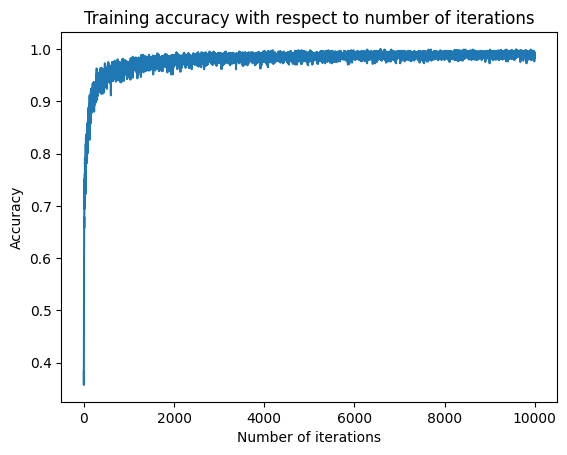

In [11]:
plt.plot(no_of_iternation, meta_train_acc)
plt.title('Training accuracy with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Error')

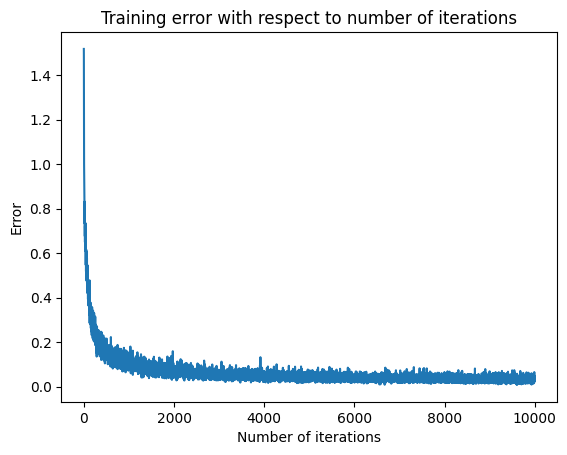

In [12]:
plt.plot(no_of_iternation, meta_train_err)
plt.title('Training error with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

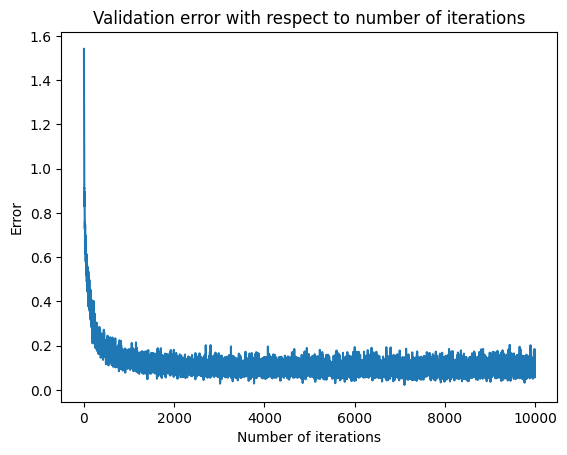

In [13]:
plt.plot(no_of_iternation, meta_val_err)
plt.title('Validation error with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

Text(0, 0.5, 'Accuracy')

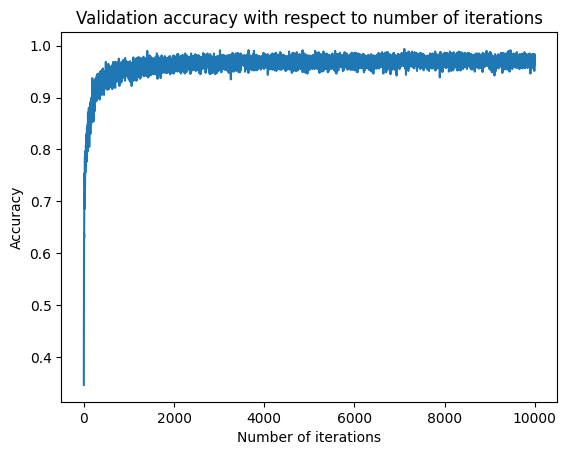

In [14]:
plt.plot(no_of_iternation, meta_val_acc)
plt.title('Validation accuracy with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')